# Feature Engineering

In [1]:
# Libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import scipy.stats
from scipy.stats import kendalltau
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm

# For processing each column
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder

In [2]:
# User-defined functions
# function to plot feature with target
def var_quant_anal(base, feat, target=None):
    '''
    Create information on quantitative variable

    Parameters:
    base: input DataFrame
    feat: feature to analyze
    target: independent variable by default none

    Returns:
    - value counts of feat (absolute and relative)
    - summary statistics
    - boxplot
    - calculates outliers and returns percentage of outliers (total, below, above)
    - calculates extreme values and returns percentage of extreme values
        (total, below, above)
    - countplot of feat
    - if target != None:
        - scatterplot between feat and target
        - correlation with Kendall's tau
    '''
    # Value counts
    print(
        'Percentage of missings:\n',
        round(base[feat].isna().mean() * 100, 2),
        '%',
        end='\n\n',
    )

    print(f'Values of {feat} \n')
    value_counts = base[feat].value_counts(dropna=False).sort_index()
    relative_counts = base[feat].value_counts(normalize=True, dropna=False).sort_index()

    result = pd.DataFrame(
        {'Absolute Count': value_counts, 'Relative Count (%)': relative_counts * 100}
    )

    print(result, end='\n\n')

    # summary statistics
    print(base[feat].describe(), end='\n\n')

    # boxplot
    sns.boxplot(data=base, x=feat)
    plt.title(f'Distribution of {feat} \n', fontsize=20)
    plt.show()

    # outliers
    q75, q25 = np.percentile(base[feat], [75, 25])
    interval = [q25 - (1.5 * (q75 - q25)), q75 + (1.5 * (q75 - q25))]

    print('Outliers (1.5*IQR) are outside of: ', interval)

    # Values below the lower threshold
    below_threshold = base[feat] < interval[0]
    below_percentage = (below_threshold.sum() / len(base[feat])) * 100
    print(f'Percentage below the lower threshold: {below_percentage:.2f}%')

    # Values above the upper threshold
    above_threshold = base[feat] > interval[1]
    above_percentage = (above_threshold.sum() / len(base[feat])) * 100
    print(f'Percentage above the upper threshold: {above_percentage:.2f}%')

    # Extreme values
    interval_ext = [q25 - (3 * (q75 - q25)), q75 + (3 * (q75 - q25))]

    print('Extreme values (3*IQR) are outside of: ', interval_ext)

    # Values below the lower threshold
    below_threshold = base[feat] < interval_ext[0]
    below_percentage = (below_threshold.sum() / len(base[feat])) * 100
    print(f'Percentage below the lower threshold: {below_percentage:.2f}%')

    # Values above the upper threshold
    above_threshold = base[feat] > interval_ext[1]
    above_percentage = (above_threshold.sum() / len(base[feat])) * 100
    print(f'Percentage above the upper threshold: {above_percentage:.2f}%')

    # countplot
    sns.displot(data=base, x=feat)
    plt.title(f'Distribution of {feat} \n', fontsize=20)
    plt.show()

    if target is not None:
        # scatterplot with target
        sns.scatterplot(data=base, x=feat, y=target, color='blue', alpha=0.7)
        plt.title(f'Distribution of {feat} by {target}\n', fontsize=20)
        plt.show()

        # Correlation test
        # dropping NA's
        corr_df = base[[feat, target]].dropna()
        tau, p_value = kendalltau(corr_df[feat], corr_df[target])
        print(f"Kendall's tau: {tau}, p-value: {p_value}")


def var_qual_anal(base, feat, target=None):
    '''
    Create information on qualitative variable

    Parameters:
    base: input DataFrame
    feat: feature to analyze
    target: independent by default none

    Returns:
    - value counts of feat (absolute and relative)
    - countplot of feat
    - if target != None:
        - overview per group on target
        - boxplot between feat and target
        - statistical test (Cramers V) between feat and target
    '''

    # value counts
    print(f'Values of {feat} \n')
    value_counts = base[feat].value_counts().sort_index()
    relative_counts = base[feat].value_counts(normalize=True).sort_index()

    result = pd.DataFrame(
        {'Absolute Count': value_counts, 'Relative Count (%)': relative_counts * 100}
    )

    print(result, end='\n\n')
    print(
        'Percentage of missings:\n',
        round(base[feat].isna().mean() * 100, 2),
        '%',
        end='\n\n',
    )

    # countplot
    sns.countplot(x=feat, data=base)
    plt.title(f'Distribution of {feat} \n', fontsize=20)
    plt.show()

    if target is not None:
        print(f'Statistics of {feat} and {target}: ', end='\n\n')
        print(base.groupby(feat)[target].describe())

        # boxplot dependent on target
        sns.boxplot(x=feat, y=target, hue=feat, data=base)
        plt.title(f'Distribution of {feat} by {target}\n', fontsize=20)
        plt.show()

        # ANOVA test
        print('ANOVA Test', end='\n')
        lm = ols(f'{target} ~ {feat}', data=base).fit()
        table = anova_lm(lm)

        f = table['F'].iloc[:1]
        p = table['PR(>F)'].iloc[:1]

        print(
            'F-value of ANOVA between feature and target:',
            round(f.iloc[0], 5),
            'at p-value:',
            round(p.iloc[0], 5),
        )

# Loading data

In [3]:
# loading data
train = pd.read_csv('data/processed/train_raw.csv', low_memory=False)

# Exploring target distribution

Percentage of missings:
 0.0 %

Values of severity_score 

                Absolute Count  Relative Count (%)
severity_score                                    
0.000000                     1            0.001052
0.018519                     1            0.001052
0.025641                     1            0.001052
0.027778                     1            0.001052
0.066667                     2            0.002104
...                        ...                 ...
9.898060                     1            0.001052
10.010423                    1            0.001052
10.207645                    2            0.002104
10.349940                    1            0.001052
10.888181                    1            0.001052

[447 rows x 2 columns]

count    95049.000000
mean         1.798234
std          1.854414
min          0.000000
25%          0.500000
50%          0.750000
75%          3.034735
max         10.888181
Name: severity_score, dtype: float64



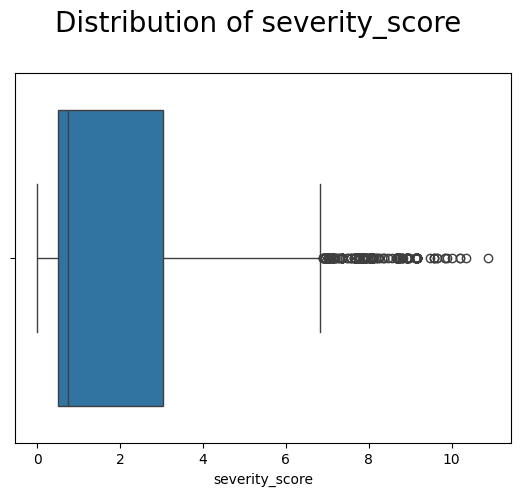

Outliers (1.5*IQR) are outside of:  [-3.3021027356851587, 6.836837892808598]
Percentage below the lower threshold: 0.00%
Percentage above the upper threshold: 2.57%
Extreme values (3*IQR) are outside of:  [-7.104205471370317, 10.638940628493756]
Percentage below the lower threshold: 0.00%
Percentage above the upper threshold: 0.00%


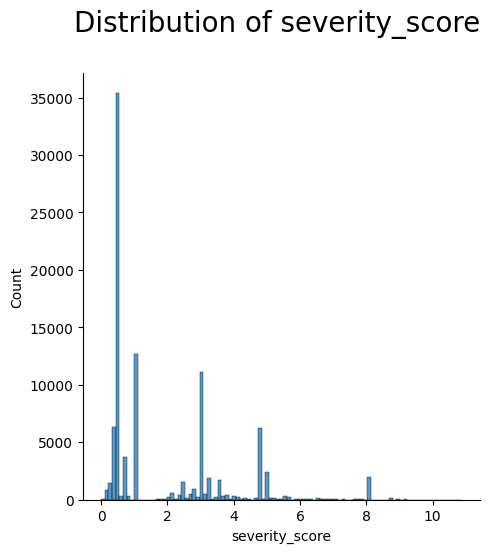

In [4]:
var_quant_anal(train, 'severity_score')

For the target, one can clearly see that it has certain extreme values due to the inclusion of mass accidents. The algorithms might be bad at capturing this, but so far, I leave the variable as it is. 

# Exploring features

The following features: `lat`, `long`, `light_condit`, `location_type`, `intersect_type`, `weather_cond`, `collision_type`, `month`, `day`, `hour`, `year`, `road_cat`, `traffic_dir`, `num_lanes`, `prof_road`, `plan_view`, `surface`, `acc_loc`

I create six lists to gather information regarding possible encoding strategies:

In [5]:
minmax_list = []
standard_list = []
robust_list = []
dummy_list = []
targetenc_list = []
cyclical_list = []
drop_list = []

## `lat`

Percentage of missings:
 0.0 %

Values of lat 

           Absolute Count  Relative Count (%)
lat                                          
42.370435               1            0.001052
42.405634               1            0.001052
42.411107               1            0.001052
42.423171               1            0.001052
42.432903               1            0.001052
...                   ...                 ...
51.061750               1            0.001052
51.062888               1            0.001052
51.068922               1            0.001052
51.069946               1            0.001052
51.072044               1            0.001052

[90152 rows x 2 columns]

count    95049.000000
mean        47.160519
std          2.183340
min         42.370435
25%         45.504572
50%         48.110802
75%         48.868596
max         51.072044
Name: lat, dtype: float64



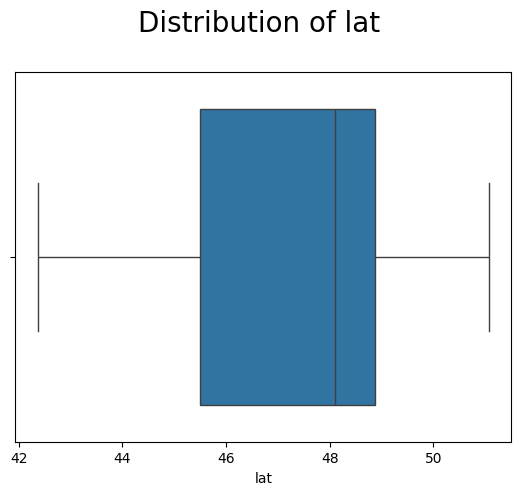

Outliers (1.5*IQR) are outside of:  [40.45853600000001, 53.91463199999998]
Percentage below the lower threshold: 0.00%
Percentage above the upper threshold: 0.00%
Extreme values (3*IQR) are outside of:  [35.41250000000002, 58.96066799999998]
Percentage below the lower threshold: 0.00%
Percentage above the upper threshold: 0.00%


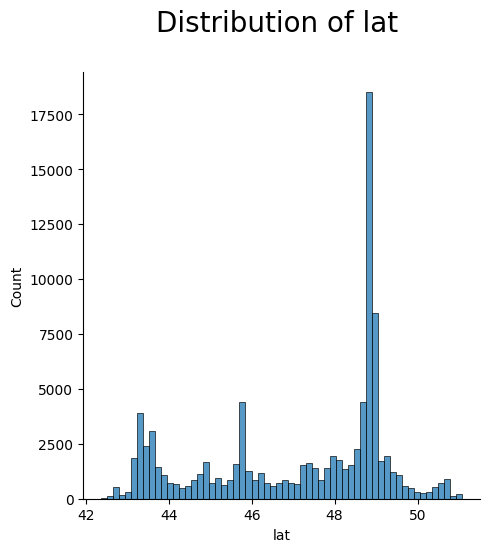

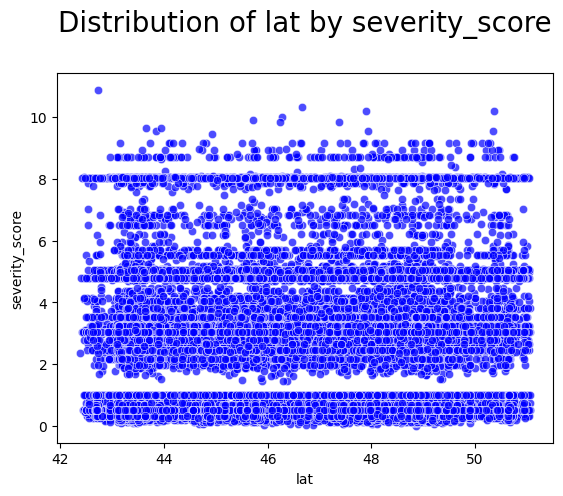

Kendall's tau: -0.11576589005348802, p-value: 0.0


In [6]:
var_quant_anal(train, 'lat', 'severity_score')

This is tricky to deal with, this it is gradients, and not numerical. Normalization won't make sense and is not needed for the tree-based algorithms. However, for neural networks as well as linear/Huber regression manipulation is needed, and I proceed with radiant transformation.

## `long`

Percentage of missings:
 0.0 %

Values of long 

           Absolute Count  Relative Count (%)
long                                         
-4.763823               1            0.001052
-4.747848               1            0.001052
-4.740751               1            0.001052
-4.740675               1            0.001052
-4.723851               1            0.001052
...                   ...                 ...
 8.157300               1            0.001052
 8.157538               1            0.001052
 8.157660               1            0.001052
 8.166779               1            0.001052
 8.172176               1            0.001052

[91017 rows x 2 columns]

count    95049.000000
mean         2.567465
std          2.479483
min         -4.763823
25%          1.433727
50%          2.389376
75%          4.504213
max          8.172176
Name: long, dtype: float64



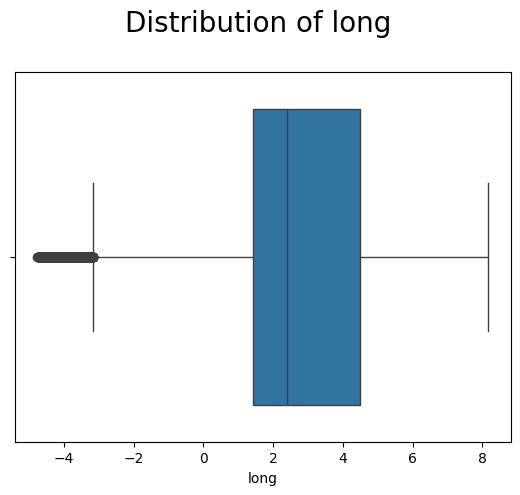

Outliers (1.5*IQR) are outside of:  [-3.172001384999999, 9.109940974999999]
Percentage below the lower threshold: 2.25%
Percentage above the upper threshold: 0.00%
Extreme values (3*IQR) are outside of:  [-7.777729769999998, 13.715669359999998]
Percentage below the lower threshold: 0.00%
Percentage above the upper threshold: 0.00%


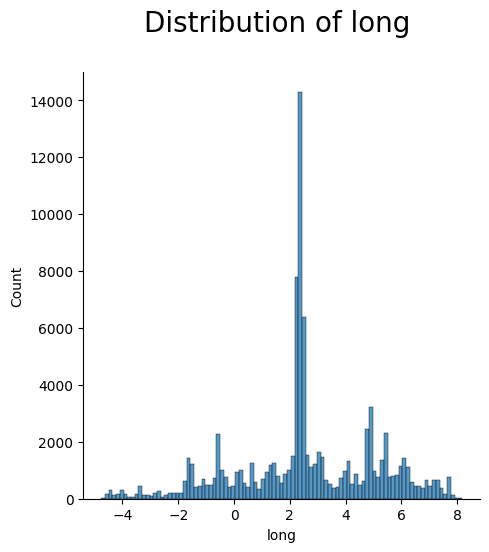

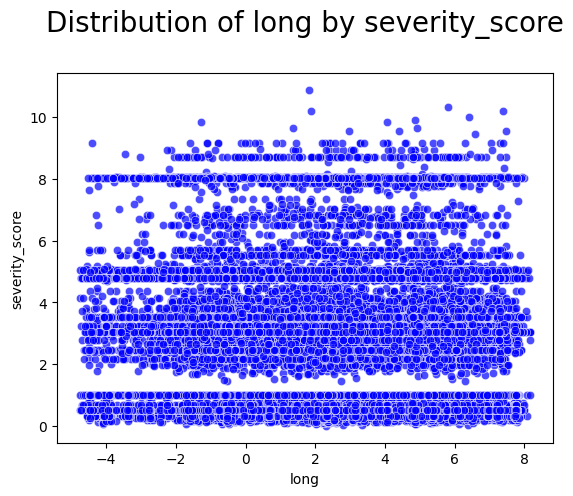

Kendall's tau: 0.01737073051120905, p-value: 7.206928435066574e-14


In [7]:
var_quant_anal(train, 'long', 'severity_score')

This is tricky to deal with, this it is gradients, and not numerical. Normalization won't make sense and is not needed for the tree-based algorithms. However, for neural networks as well as linear/Huber regression manipulation is needed, and I proceed with radiant transformation.

## `light_condit`

The feature is highly imbalanced with 68% on category 1. I tried below to gather 4 and 5 in one group.

| old | description | new |
| -- | ------ | -- |
| 1 | "Full day" | 1 |
| 2 | "Twilight or dawn" | 2 |
| 3 | "Night without public lighting" | 3 |
| 4 | "Night with public lighting not lit" | 4 |
| 5 | "Night with public lighting on" | 4 | 

Values of light_condit 

              Absolute Count  Relative Count (%)
light_condit                                    
1.0                    62906           66.184098
2.0                     6452            6.788221
3.0                     9874           10.388545
4.0                      934            0.982672
5.0                    14881           15.656465

Percentage of missings:
 0.0 %



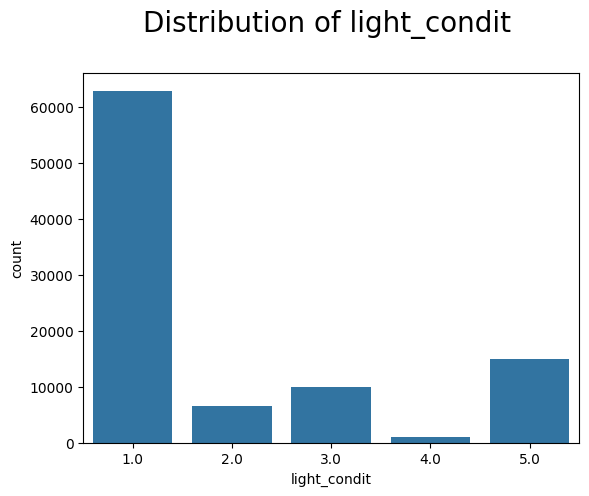

Statistics of light_condit and severity_score: 

                count      mean       std       min       25%       50%  \
light_condit                                                              
1.0           62906.0  1.718915  1.780795  0.018519  0.500000  0.666667   
2.0            6452.0  1.969035  1.948826  0.076923  0.500000  1.000000   
3.0            9874.0  2.717290  2.252928  0.066667  0.666667  2.451402   
4.0             934.0  2.155166  2.107187  0.142857  0.500000  1.000000   
5.0           14881.0  1.427124  1.587697  0.000000  0.500000  0.500000   

                   75%        max  
light_condit                       
1.0           3.034735  10.888181  
2.0           3.034735   9.153322  
3.0           4.784735   9.837407  
4.0           3.113745   9.565205  
5.0           2.384735   9.898060  


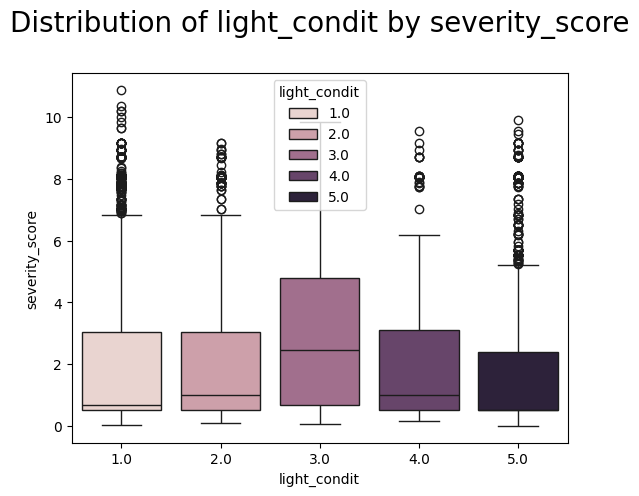

ANOVA Test
F-value of ANOVA between feature and target: 4.67026 at p-value: 0.03069


In [8]:
var_qual_anal(train, 'light_condit', 'severity_score')

Values of light_condit 

              Absolute Count  Relative Count (%)
light_condit                                    
1.0                    62906           66.184098
2.0                     6452            6.788221
3.0                     9874           10.388545
4.0                    15815           16.639136

Percentage of missings:
 0.0 %



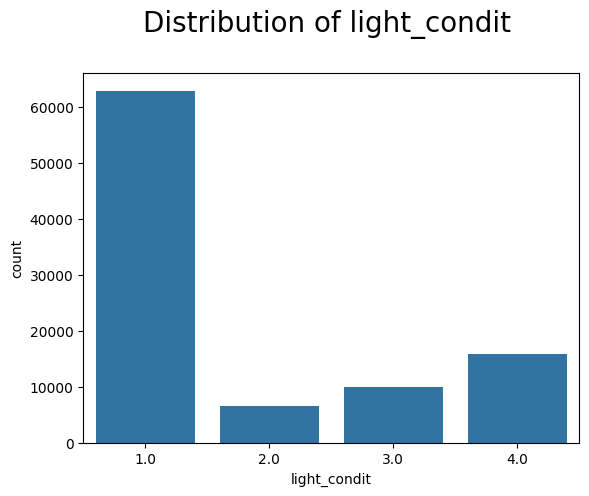

Statistics of light_condit and severity_score: 

                count      mean       std       min       25%       50%  \
light_condit                                                              
1.0           62906.0  1.718915  1.780795  0.018519  0.500000  0.666667   
2.0            6452.0  1.969035  1.948826  0.076923  0.500000  1.000000   
3.0            9874.0  2.717290  2.252928  0.066667  0.666667  2.451402   
4.0           15815.0  1.470121  1.631969  0.000000  0.500000  0.500000   

                   75%        max  
light_condit                       
1.0           3.034735  10.888181  
2.0           3.034735   9.153322  
3.0           4.784735   9.837407  
4.0           2.451402   9.898060  


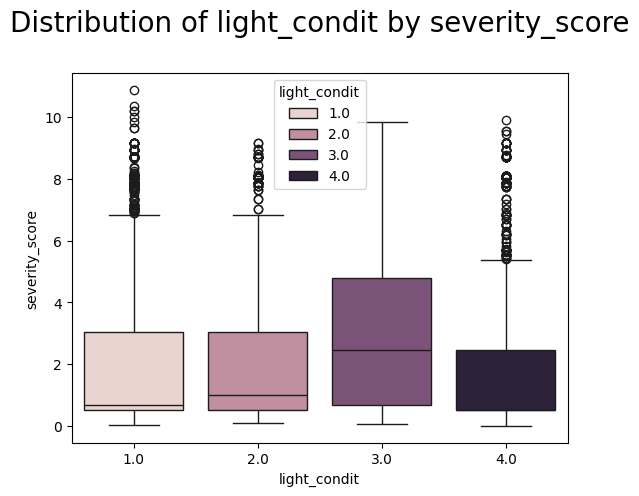

ANOVA Test
F-value of ANOVA between feature and target: 30.11447 at p-value: 0.0


In [9]:
light_map = {
    1: 1,
    2: 2, 
    3: 3, 
    4: 4, 
    5: 4
}

train['light_condit'] = train['light_condit'].map(light_map)

var_qual_anal(train, 'light_condit', 'severity_score')

This it has only four categories, I do dummy encoding.

In [10]:
dummy_list.append('light_condit')

## `location_type`

Values of location_type 

               Absolute Count  Relative Count (%)
location_type                                    
1                       34869           36.685289
2                       60180           63.314711

Percentage of missings:
 0.0 %



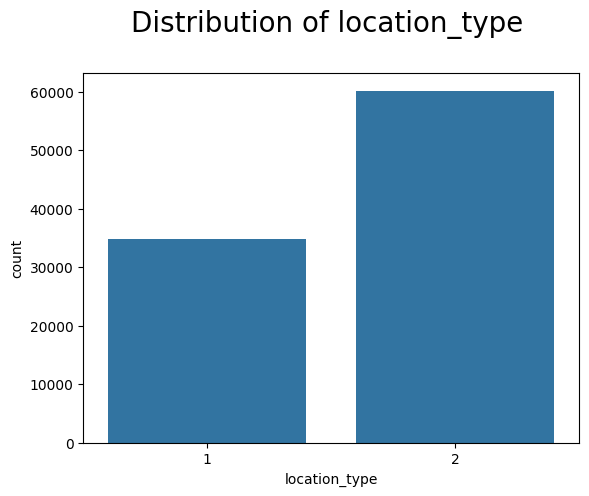

Statistics of location_type and severity_score: 

                 count      mean       std       min  25%       50%       75%  \
location_type                                                                   
1              34869.0  2.505632  2.136426  0.018519  0.5  2.384735  4.047673   
2              60180.0  1.388359  1.526059  0.000000  0.5  0.500000  2.451402   

                     max  
location_type             
1              10.888181  
2              10.010423  


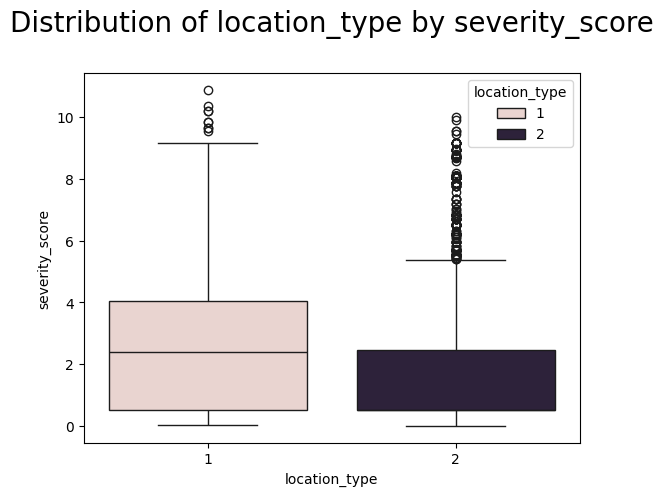

ANOVA Test
F-value of ANOVA between feature and target: 8751.8402 at p-value: 0.0


In [11]:
var_qual_anal(train, 'location_type', 'severity_score')

In [12]:
dummy_list.append('location_type')

## `intersect_type`

The variable is highly imbalanced and a lot of groups have only a few entries.

| old | description | new |
| --| ------ | -- |
| 1 | "Out of intersection" | 1 |
| 2 | "Intersection in X" | 2 |
| 3 | "Intersection in T" | 2 |
| 4 | "Intersection in Y" | 2 |
| 5 | "Intersection with more than 4 branches" | 2 |
| 6 | "Giratory" | 3 |
| 7 | "Place" | 3 |
| 8 | "Level crossing" | 3 |
| 9 | "Other intersection" | 3 |

I will recode the variable to represent less groups. 

Values of intersect_type 

                Absolute Count  Relative Count (%)
intersect_type                                    
1.0                      60360           63.508765
2.0                      12077           12.707014
3.0                      10680           11.237137
4.0                       2130            2.241114
5.0                        592            0.622883
6.0                       4141            4.357021
7.0                        977            1.027967
8.0                        200            0.210433
9.0                       3885            4.087667

Percentage of missings:
 0.01 %



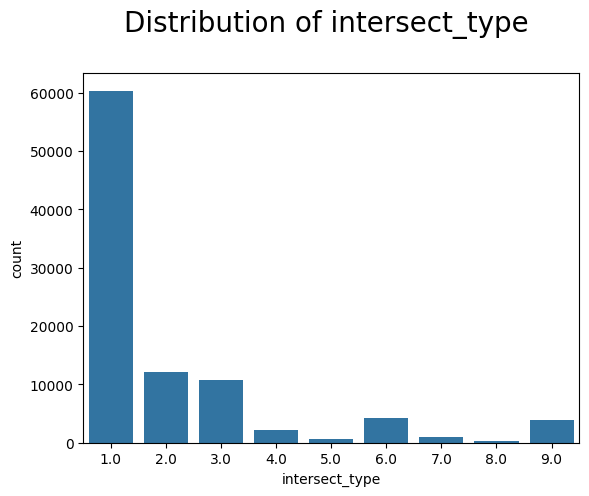

Statistics of intersect_type and severity_score: 

                  count      mean       std       min  25%       50%  \
intersect_type                                                         
1.0             60360.0  2.006397  1.992145  0.000000  0.5  1.000000   
2.0             12077.0  1.317289  1.399724  0.111111  0.5  0.500000   
3.0             10680.0  1.434169  1.487194  0.100000  0.5  0.500000   
4.0              2130.0  1.636878  1.681043  0.018519  0.5  0.600000   
5.0               592.0  0.988779  1.151359  0.111111  0.5  0.500000   
6.0              4141.0  1.577545  1.684489  0.090909  0.5  0.500000   
7.0               977.0  1.024414  1.177243  0.142857  0.5  0.500000   
8.0               200.0  2.181682  1.955807  0.200000  0.5  1.000000   
9.0              3885.0  1.682717  1.700266  0.076923  0.5  0.666667   

                     75%        max  
intersect_type                       
1.0             3.034735  10.888181  
2.0             2.451402   9.153322  
3.0 

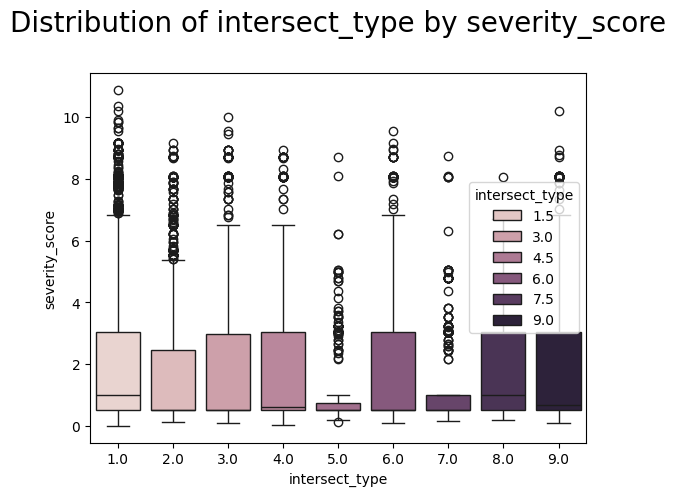

ANOVA Test
F-value of ANOVA between feature and target: 646.73623 at p-value: 0.0


In [13]:
var_qual_anal(train, 'intersect_type', 'severity_score')

Values of intersect_type 

                Absolute Count  Relative Count (%)
intersect_type                                    
1.0                      60360           63.508765
2.0                      25479           26.808148
3.0                       9203            9.683087

Percentage of missings:
 0.01 %



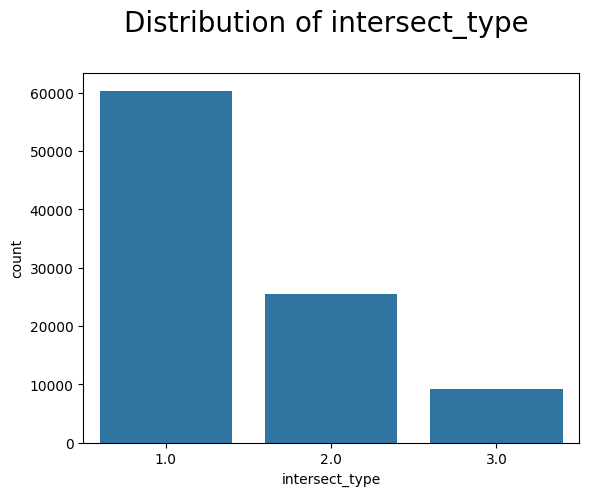

Statistics of intersect_type and severity_score: 

                  count      mean       std       min  25%  50%       75%  \
intersect_type                                                              
1.0             60360.0  2.006397  1.992145  0.000000  0.5  1.0  3.034735   
2.0             25479.0  1.385366  1.461061  0.018519  0.5  0.5  2.642440   
3.0              9203.0  1.576351  1.664812  0.076923  0.5  0.5  3.034735   

                      max  
intersect_type             
1.0             10.888181  
2.0             10.010423  
3.0             10.207645  


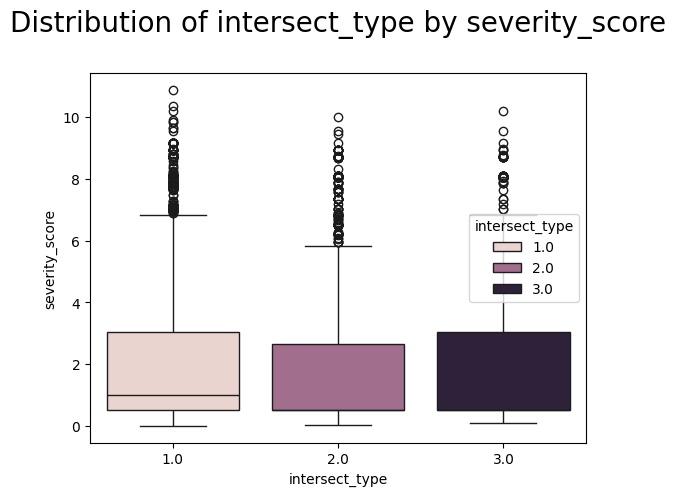

ANOVA Test
F-value of ANOVA between feature and target: 1499.08452 at p-value: 0.0


In [14]:
intersect_map = {
    1: 1,
    2: 2,
    3: 2,
    4: 2,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9: 3,
}

train['intersect_type'] = train['intersect_type'].map(intersect_map)

var_qual_anal(train, 'intersect_type', 'severity_score')

Since, I only have now three groups, I will encode it with dummies.

In [15]:
dummy_list.append('intersect_type')

## `weather_cond`

Again, we have a lot of groups and some only a few cases. 

| old | description | new |
| -- | ------ | -- |
| 1 | "Normal" | 1 |
| 2 | "Light rain" | 2 |
| 3 | "Heavy rain" | 2 |
| 4 | "Snow - hail" | 2 |
| 5 | "Fog - smoke" | 2 |
| 6 | "Strong wind - storm" | 2 |
| 7 | "Dazzling weather" | 2 |
| 8 | "Cloudy weather" | 2 |
| 9 | "Other" | 2 |

Values of weather_cond 

              Absolute Count  Relative Count (%)
weather_cond                                    
1.0                    75024           78.935241
2.0                    10349           10.888526
3.0                     2192            2.306276
4.0                      323            0.339839
5.0                      715            0.752275
6.0                      282            0.296702
7.0                     1850            1.946446
8.0                     3847            4.047556
9.0                      463            0.487138

Percentage of missings:
 0.0 %



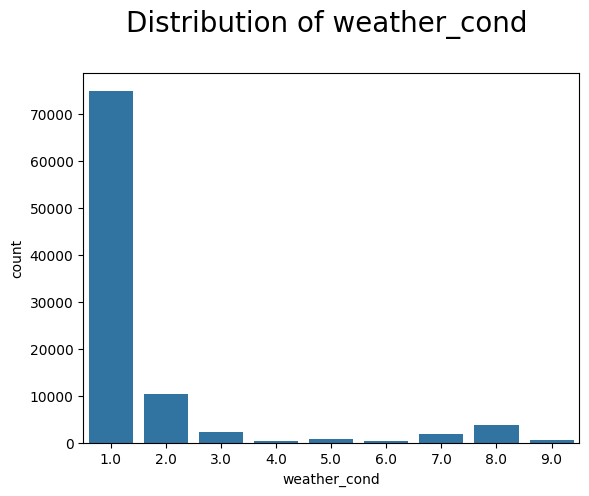

Statistics of weather_cond and severity_score: 

                count      mean       std       min  25%       50%       75%  \
weather_cond                                                                   
1.0           75024.0  1.792110  1.847786  0.000000  0.5  0.666667  3.034735   
2.0           10349.0  1.634298  1.796203  0.076923  0.5  0.666667  3.034735   
3.0            2192.0  1.781295  1.797828  0.142857  0.5  1.000000  3.034735   
4.0             323.0  1.992712  1.912014  0.142857  0.5  1.000000  3.034735   
5.0             715.0  2.644490  2.283000  0.200000  0.5  2.405990  4.784735   
6.0             282.0  2.688010  2.131010  0.193548  0.5  2.784735  4.767136   
7.0            1850.0  2.298274  1.814774  0.133333  0.5  2.784735  3.034735   
8.0            3847.0  1.814391  1.913384  0.166667  0.5  0.750000  3.034735   
9.0             463.0  2.403068  2.170600  0.200000  0.5  1.000000  3.534735   

                    max  
weather_cond             
1.0           10.8

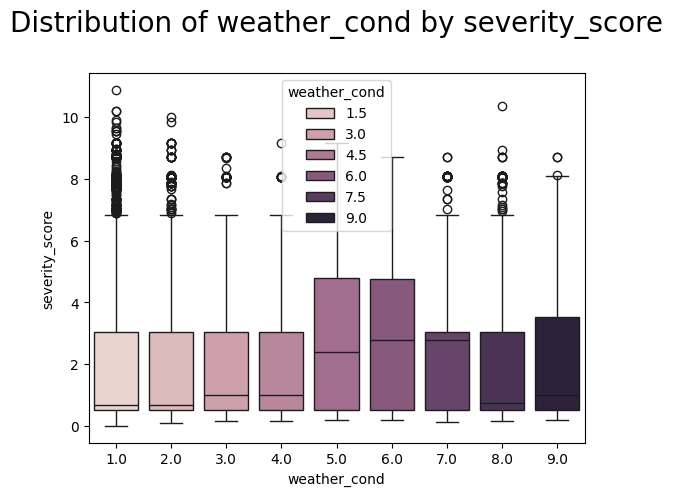

ANOVA Test
F-value of ANOVA between feature and target: 108.79396 at p-value: 0.0


In [16]:
var_qual_anal(train, 'weather_cond', 'severity_score')

Values of weather_cond 

              Absolute Count  Relative Count (%)
weather_cond                                    
1.0                    75024           78.935241
2.0                    20021           21.064759

Percentage of missings:
 0.0 %



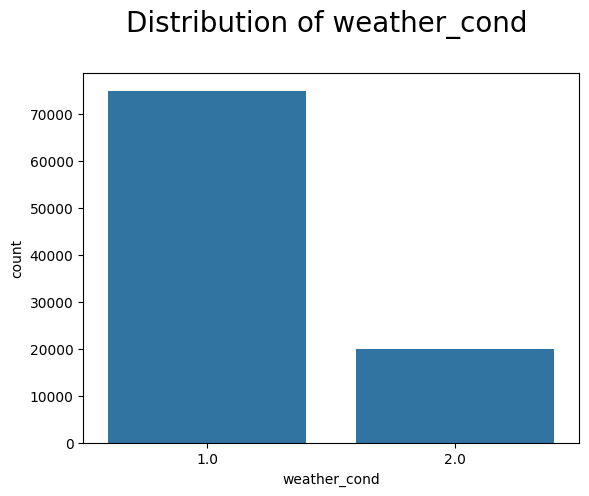

Statistics of weather_cond and severity_score: 

                count      mean       std       min  25%       50%       75%  \
weather_cond                                                                   
1.0           75024.0  1.792110  1.847786  0.000000  0.5  0.666667  3.034735   
2.0           20021.0  1.820829  1.878399  0.076923  0.5  1.000000  3.034735   

                    max  
weather_cond             
1.0           10.888181  
2.0           10.349940  


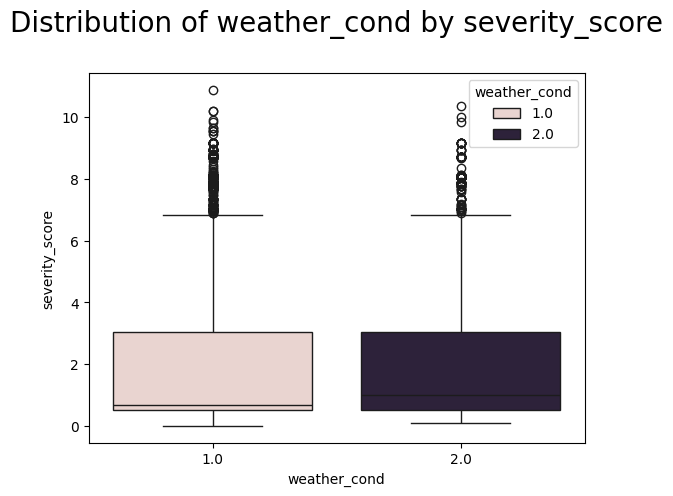

ANOVA Test
F-value of ANOVA between feature and target: 3.79096 at p-value: 0.05153


In [17]:
weather_map = {
    1: 1,
    2: 2,
    3: 2,
    4: 2,
    5: 2,
    6: 2,
    7: 2,
    8: 2,
    9: 2
}

train['weather_cond'] = train['weather_cond'].map(weather_map)

var_qual_anal(train, 'weather_cond', 'severity_score')

In [18]:
dummy_list.append('weather_cond')

## `collision_type`

Some groups have only low n. 

| old | description | new |
| -- | ------ | -- |
| 1 | "Two vehicles - frontal" | 1 |
| 2 | "Two vehicles - from the rear" | 1 |
| 3 | "Two vehicles - by the side" | 1 |
| 4 | "Three vehicles and more - in chain" | 2 |
| 5 | "Three or more vehicles - multiple collisions" | 2 |
| 6 | "Other collision" | 2 |
| 7 | "Without collision" | 3 |
| NA | NA | mode |


Values of collision_type 

                Absolute Count  Relative Count (%)
collision_type                                    
1.0                       9849           10.368132
2.0                      12528           13.188340
3.0                      28505           30.007474
4.0                       3370            3.547630
5.0                       2754            2.899161
6.0                      28738           30.252755
7.0                       9249            9.736507

Percentage of missings:
 0.06 %



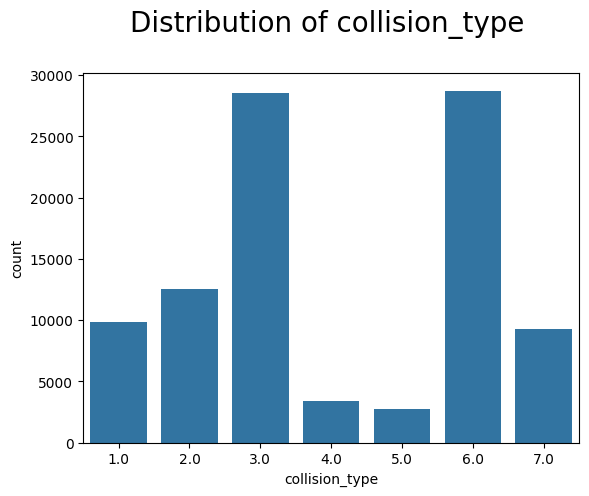

Statistics of collision_type and severity_score: 

                  count      mean       std       min       25%       50%  \
collision_type                                                              
1.0              9849.0  2.281188  1.892789  0.018519  0.500000  2.451402   
2.0             12528.0  1.136511  1.244358  0.111111  0.500000  0.500000   
3.0             28505.0  1.288141  1.327579  0.100000  0.500000  0.500000   
4.0              3370.0  0.792532  0.992099  0.000000  0.333333  0.333333   
5.0              2754.0  1.525172  1.616110  0.076923  0.333333  0.666667   
6.0             28738.0  2.230761  2.121763  0.027778  0.500000  1.000000   
7.0              9249.0  2.852120  2.263005  0.076923  1.000000  1.000000   

                     75%        max  
collision_type                       
1.0             3.225773  10.888181  
2.0             1.000000   8.701920  
3.0             2.451402  10.207645  
4.0             0.666667   7.856779  
5.0             2.451402   

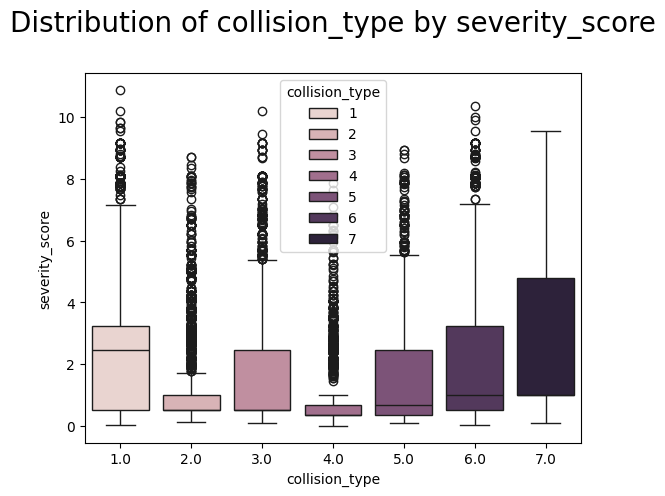

ANOVA Test
F-value of ANOVA between feature and target: 4061.9936 at p-value: 0.0


In [19]:
var_qual_anal(train, 'collision_type', 'severity_score')

Values of collision_type 

                Absolute Count  Relative Count (%)
collision_type                                    
1.0                      50938           53.591306
2.0                      34862           36.677924
3.0                       9249            9.730770

Percentage of missings:
 0.0 %



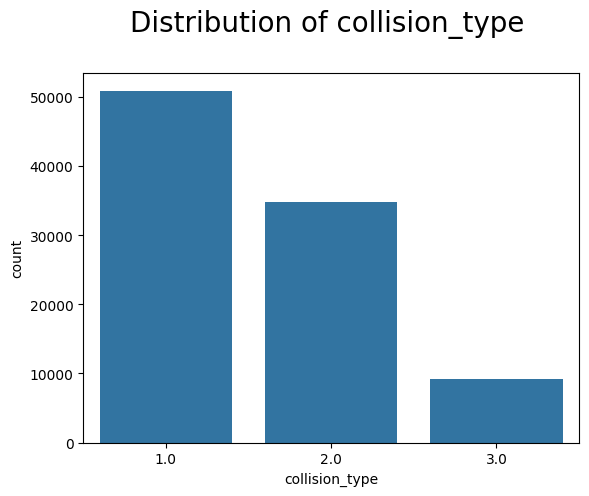

Statistics of collision_type and severity_score: 

                  count      mean       std       min  25%  50%       75%  \
collision_type                                                              
1.0             50938.0  1.444153  1.495812  0.018519  0.5  0.5  3.034735   
2.0             34862.0  2.035992  2.052747  0.000000  0.5  1.0  3.034735   
3.0              9249.0  2.852120  2.263005  0.076923  1.0  1.0  4.784735   

                      max  
collision_type             
1.0             10.888181  
2.0             10.349940  
3.0              9.565205  


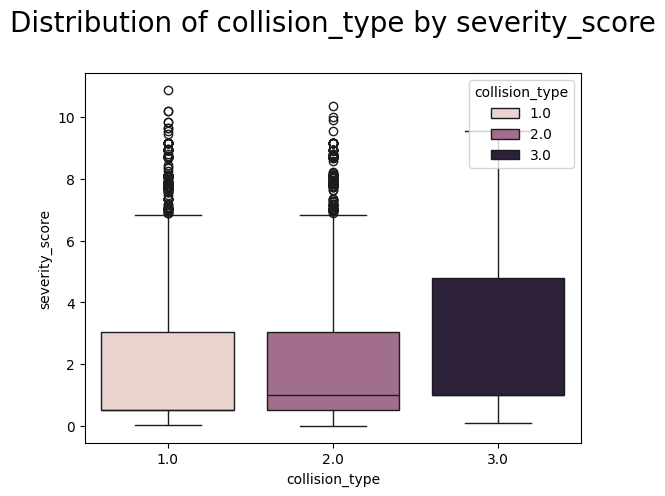

ANOVA Test
F-value of ANOVA between feature and target: 5676.97244 at p-value: 0.0


In [20]:
collision_map = {
    1: 1,
    2: 1,
    3: 1,
    4: 2,
    5: 2,
    6: 2,
    7: 3,
}

train['collision_type'] = train['collision_type'].map(collision_map)

train['collision_type'] = train['collision_type'].fillna(train['collision_type'].mode()[0])

var_qual_anal(train, 'collision_type', 'severity_score')

In [21]:
dummy_list.append('collision_type')

## `month`

The ANOVA gives a significant test result, however, the mean differences by severity are not super high. It ranges from $[2.23, 2.61]$. Highest values are reached in July, August. So far we keep this variable, distribution in the variable is balanced.

Values of month 

       Absolute Count  Relative Count (%)
month                                    
1                8692            9.144757
2                8732            9.186840
3                7245            7.622384
4                6320            6.649202
5                8129            8.552431
6                9047            9.518248
7                8074            8.494566
8                7059            7.426696
9                8605            9.053225
10               8611            9.059538
11               7672            8.071626
12               6863            7.220486

Percentage of missings:
 0.0 %



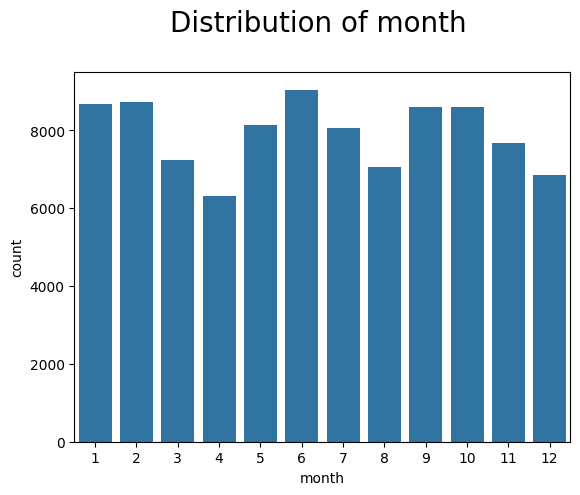

Statistics of month and severity_score: 

        count      mean       std       min  25%       50%       75%  \
month                                                                  
1      8692.0  1.695184  1.825778  0.090909  0.5  0.666667  3.034735   
2      8732.0  1.724938  1.812391  0.100000  0.5  0.666667  3.034735   
3      7245.0  1.644824  1.769030  0.025641  0.5  0.500000  3.034735   
4      6320.0  1.758771  1.836110  0.027778  0.5  0.666667  3.034735   
5      8129.0  1.867040  1.860523  0.100000  0.5  1.000000  3.034735   
6      9047.0  1.812368  1.854211  0.111111  0.5  0.750000  3.034735   
7      8074.0  2.004626  1.945087  0.018519  0.5  1.000000  3.034735   
8      7059.0  2.049903  1.942983  0.076923  0.5  1.000000  3.034735   
9      8605.0  1.826194  1.852679  0.076923  0.5  0.875000  3.034735   
10     8611.0  1.752260  1.828938  0.000000  0.5  0.666667  3.034735   
11     7672.0  1.689334  1.800526  0.076923  0.5  0.666667  3.034735   
12     6863.0  1.76285

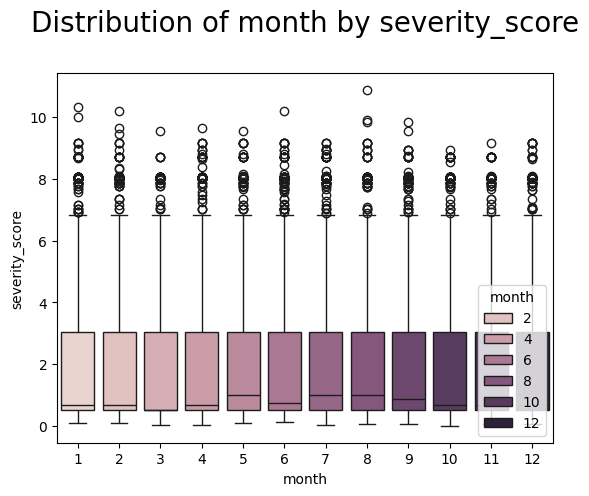

ANOVA Test
F-value of ANOVA between feature and target: 21.04838 at p-value: 0.0


In [22]:
var_qual_anal(train, 'month', 'severity_score')

Here we see some seasonality that in some months accidents are more frequent and more severe. Hence, I do cyclical encoding.

In [23]:
cyclical_list.append('month')

## `weekday`

We see clear differences between working days and weekends. We will keep this variable and do target-encoding.

Values of weekday 

         Absolute Count  Relative Count (%)
weekday                                    
0                 12812           13.479363
1                 13751           14.467275
2                 13952           14.678745
3                 13832           14.552494
4                 15673           16.489390
5                 13553           14.258961
6                 11476           12.073772

Percentage of missings:
 0.0 %



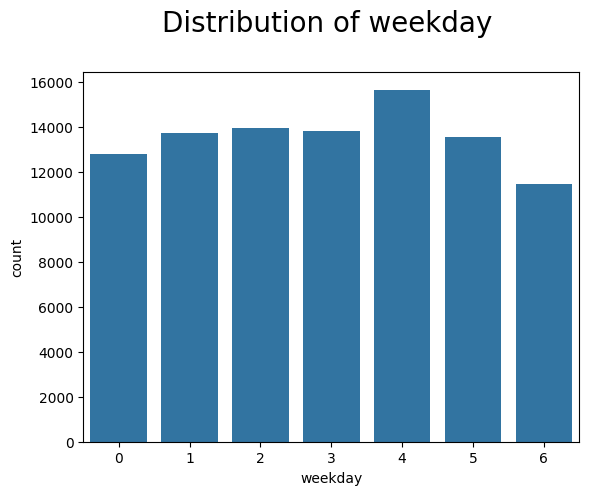

Statistics of weekday and severity_score: 

           count      mean       std       min  25%       50%       75%  \
weekday                                                                   
0        12812.0  1.712205  1.800566  0.018519  0.5  0.666667  3.034735   
1        13751.0  1.635866  1.742627  0.027778  0.5  0.500000  3.034735   
2        13952.0  1.672595  1.767134  0.090909  0.5  0.666667  3.034735   
3        13832.0  1.690929  1.779183  0.025641  0.5  0.600000  3.034735   
4        15673.0  1.760737  1.810878  0.000000  0.5  0.666667  3.034735   
5        13553.0  2.019131  1.975927  0.066667  0.5  1.000000  3.034735   
6        11476.0  2.161244  2.063967  0.076923  0.5  1.000000  3.225773   

               max  
weekday             
0         8.927693  
1         9.653445  
2        10.349940  
3         9.837407  
4        10.888181  
5         9.565205  
6        10.207645  


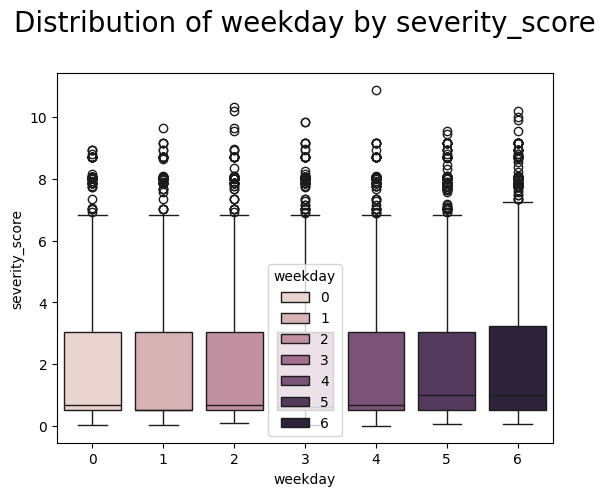

ANOVA Test
F-value of ANOVA between feature and target: 615.88892 at p-value: 0.0


In [24]:
var_qual_anal(train, 'weekday', 'severity_score')

In this case, we see some difference on weekends. I do again cyclical enoding. 

In [25]:
cyclical_list.append('weekday')

## `hour`

Values of hour 

      Absolute Count  Relative Count (%)
hour                                    
0               1764            1.855885
1               1493            1.570769
2               1294            1.361403
3               1038            1.092068
4               1076            1.132048
5               1431            1.505539
6               2030            2.135741
7               4262            4.484003
8               5681            5.976917
9               4729            4.975329
10              4357            4.583951
11              4611            4.851182
12              4969            5.227830
13              4678            4.921672
14              5047            5.309893
15              5726            6.024261
16              6982            7.345685
17              8212            8.639754
18              8000            8.416711
19              6050            6.365138
20              4140            4.355648
21              2867            3.016339

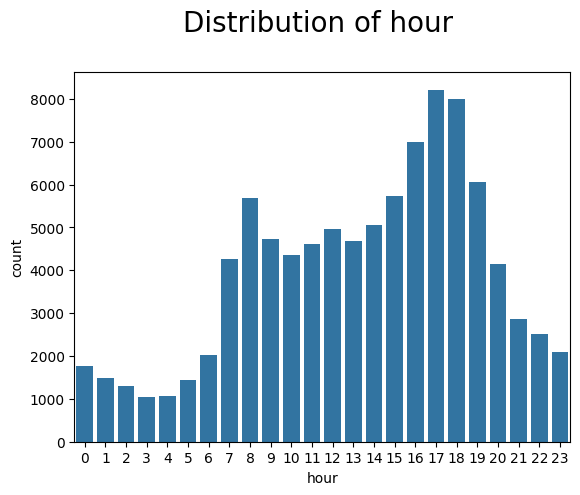

Statistics of hour and severity_score: 

       count      mean       std       min       25%       50%       75%  \
hour                                                                       
0     1764.0  2.184460  2.163477  0.100000  0.500000  1.000000  3.534735   
1     1493.0  2.391262  2.209186  0.000000  0.500000  1.000000  4.047673   
2     1294.0  2.367639  2.172356  0.142857  0.666667  1.000000  4.142440   
3     1038.0  2.516090  2.303879  0.142857  0.666667  1.000000  4.784735   
4     1076.0  2.544703  2.258058  0.142857  0.666667  1.000000  4.784735   
5     1431.0  2.329649  2.146703  0.076923  0.500000  1.000000  3.725773   
6     2030.0  2.127967  2.098043  0.142857  0.500000  1.000000  3.118068   
7     4262.0  1.730809  1.761000  0.142857  0.500000  0.666667  3.034735   
8     5681.0  1.507610  1.660881  0.090909  0.500000  0.500000  3.034735   
9     4729.0  1.553878  1.706098  0.100000  0.500000  0.500000  3.034735   
10    4357.0  1.729895  1.775653  0.018519  0.5

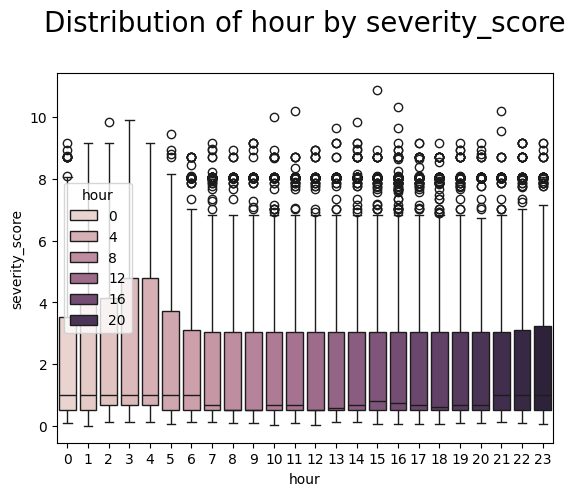

ANOVA Test
F-value of ANOVA between feature and target: 112.18258 at p-value: 0.0


In [26]:
var_qual_anal(train, 'hour', 'severity_score')

Regarding `hour`, we can see that during the day mean and median are lower and during evening and early morning scores are higher. I encode the feature with cyclical encoding.

In [27]:
cyclical_list.append('hour')

## `year`

Percentage of missings:
 0.0 %

Values of year 

      Absolute Count  Relative Count (%)
year                                    
2019           13429           14.128502
2021            4517            4.752286
2022           38823           40.845248
2023           38280           40.273964

count    95049.000000
mean      2021.931362
std          1.310395
min       2019.000000
25%       2022.000000
50%       2022.000000
75%       2023.000000
max       2023.000000
Name: year, dtype: float64



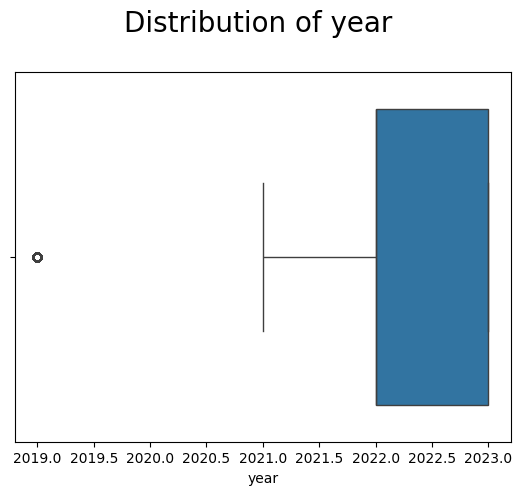

Outliers (1.5*IQR) are outside of:  [2020.5, 2024.5]
Percentage below the lower threshold: 14.13%
Percentage above the upper threshold: 0.00%
Extreme values (3*IQR) are outside of:  [2019.0, 2026.0]
Percentage below the lower threshold: 0.00%
Percentage above the upper threshold: 0.00%


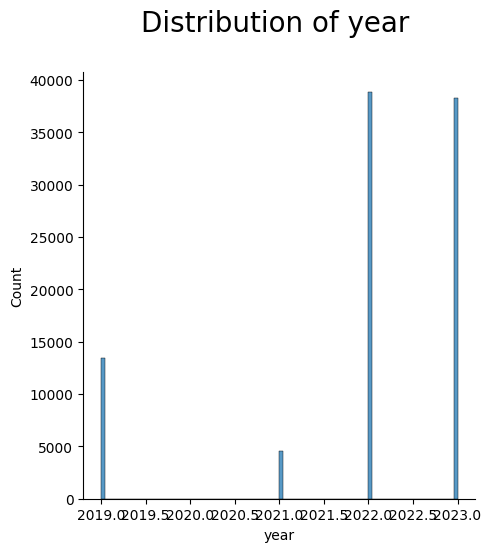

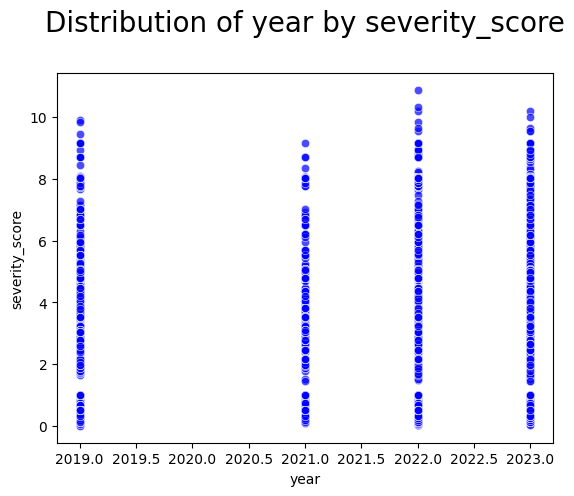

Kendall's tau: -0.0018542810231477595, p-value: 0.48866599215795015


In [28]:
var_quant_anal(train, 'year', 'severity_score')

Since we cannot see any linear relation to the target, 

In [29]:
dummy_list.append('year')

## `road_cat`

In some groups only low n. 


| old | description | new |
| -- | ------ | -- |
| 1 | "Highway" | 1 |
| 2 | "National Road" | 1 |
| 3 | "Departmental Road" | 2 |
| 4 | "Communal Way" | 3 |
| 5 | "Off public network" | 3 |
| 6 | "Parking lot open to public traffic" | 3 |
| 7 | "Urban metropolis roads" | 3 |
| 9 | "Other" | 3 |

Values of road_cat 

          Absolute Count  Relative Count (%)
road_cat                                    
1.0                 9399            9.888584
2.0                 4179            4.396680
3.0                36617           38.524340
4.0                40492           42.601185
5.0                  104            0.109417
6.0                  714            0.751191
7.0                 3101            3.262528
9.0                  443            0.466075

Percentage of missings:
 0.0 %



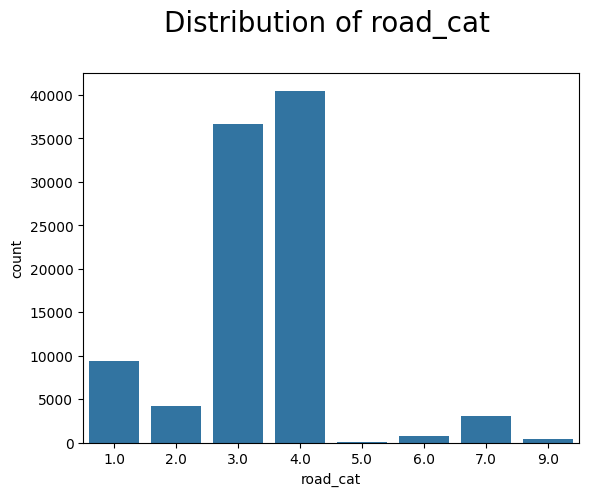

Statistics of road_cat and severity_score: 

            count      mean       std       min  25%       50%       75%  \
road_cat                                                                   
1.0        9399.0  1.362207  1.589152  0.066667  0.5  0.600000  1.000000   
2.0        4179.0  1.825138  1.882017  0.025641  0.5  1.000000  3.034735   
3.0       36617.0  2.421752  2.071536  0.018519  0.5  2.409735  3.534735   
4.0       40492.0  1.332565  1.510016  0.000000  0.5  0.500000  1.000000   
5.0         104.0  2.348775  2.003029  0.333333  0.5  1.725701  3.159735   
6.0         714.0  1.731746  1.597181  0.200000  0.5  0.666667  3.034735   
7.0        3101.0  1.724861  1.771500  0.100000  0.5  0.666667  3.034735   
9.0         443.0  2.312840  2.091649  0.200000  0.5  1.000000  3.034735   

                max  
road_cat             
1.0       10.207645  
2.0       10.888181  
3.0       10.207645  
4.0        9.565205  
5.0        8.082408  
6.0        8.082408  
7.0        9.89806

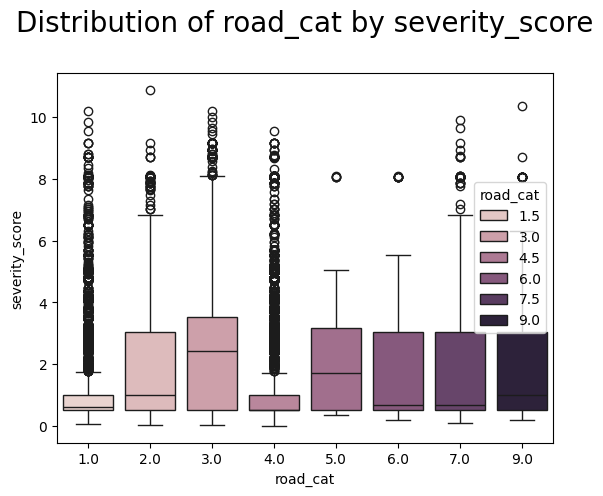

ANOVA Test
F-value of ANOVA between feature and target: 219.78765 at p-value: 0.0


In [30]:
var_qual_anal(train, 'road_cat', 'severity_score')

Values of road_cat 

          Absolute Count  Relative Count (%)
road_cat                                    
1                  13578           14.285263
2                  36617           38.524340
3                  44854           47.190397

Percentage of missings:
 0.0 %



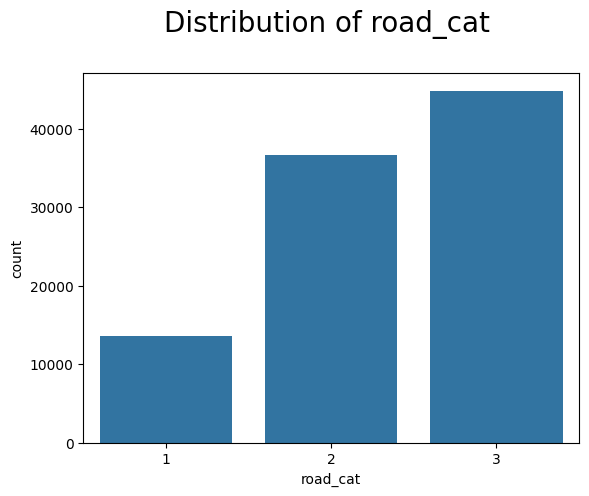

Statistics of road_cat and severity_score: 

            count      mean       std       min  25%       50%       75%  \
road_cat                                                                   
1         13578.0  1.504687  1.698149  0.025641  0.5  0.666667  2.409735   
2         36617.0  2.421752  2.071536  0.018519  0.5  2.409735  3.534735   
3         44854.0  1.378079  1.546340  0.000000  0.5  0.500000  2.159735   

                max  
road_cat             
1         10.888181  
2         10.207645  
3         10.349940  


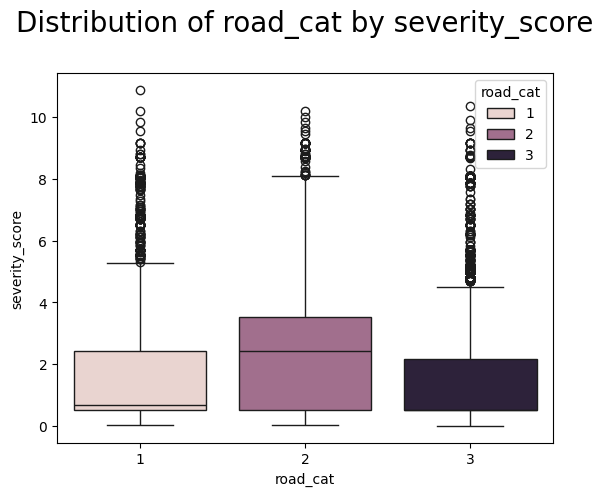

ANOVA Test
F-value of ANOVA between feature and target: 1352.80821 at p-value: 0.0


In [31]:
road_mapping = {
    1: 1,
    2: 1,
    3: 2,
    4: 3,
    5: 3,
    6: 3,
    7: 3,
    9: 3
}

train['road_cat'] = train['road_cat'].map(road_mapping)

var_qual_anal(train, 'road_cat', 'severity_score')

Due to now only 3 categories, I do dummy encoding.

In [32]:
dummy_list.append('road_cat')

## `traffic_dir`

Low cases in group 4. 

| old | description | new |
| -- | ------ | -- |
| 1 | "One way" | 1 |
| 2 | "Bidirectional" | 2 |
| 3 | "With separate carriageways" | 3 |
| 4 | "With variable allocation channels" | 3 |
| NA | NA | mode |

Values of traffic_dir 

             Absolute Count  Relative Count (%)
traffic_dir                                    
1.0                   17048           19.125616
2.0                   58142           65.227683
3.0                   13404           15.037527
4.0                     543            0.609175

Percentage of missings:
 6.22 %



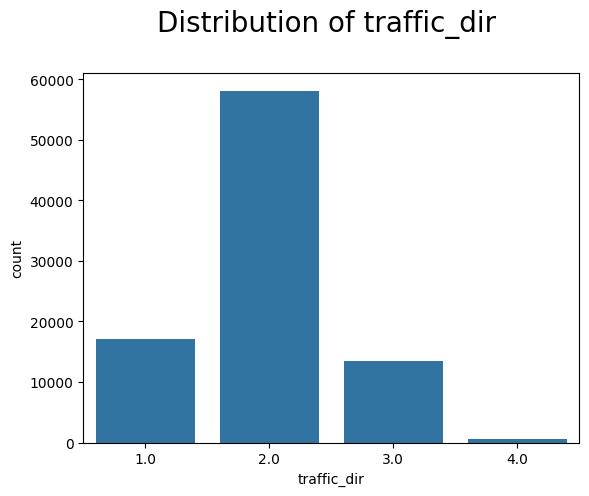

Statistics of traffic_dir and severity_score: 

               count      mean       std       min  25%       50%       75%  \
traffic_dir                                                                   
1.0          17048.0  1.163567  1.355602  0.000000  0.5  0.500000  1.000000   
2.0          58142.0  2.087775  1.974314  0.018519  0.5  1.000000  3.034735   
3.0          13404.0  1.520394  1.713168  0.066667  0.5  0.666667  2.451402   
4.0            543.0  1.424149  1.467656  0.142857  0.5  0.500000  3.034735   

                   max  
traffic_dir             
1.0           9.177672  
2.0          10.888181  
3.0          10.207645  
4.0           8.047673  


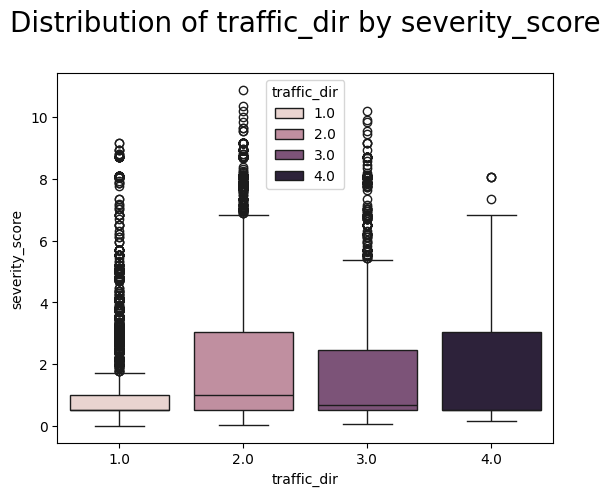

ANOVA Test
F-value of ANOVA between feature and target: 402.56329 at p-value: 0.0


In [33]:
var_qual_anal(train, 'traffic_dir', 'severity_score')

In [34]:
train['traffic_dir'].mode()[0]

2.0

Values of traffic_dir 

             Absolute Count  Relative Count (%)
traffic_dir                                    
1.0                   17048           17.936012
2.0                   64054           67.390504
3.0                   13947           14.673484

Percentage of missings:
 0.0 %



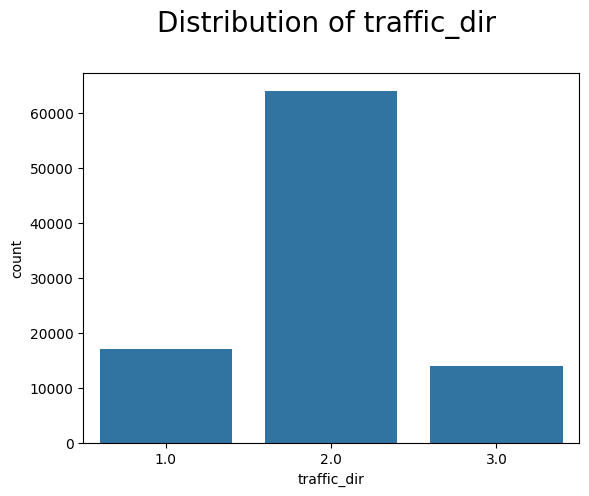

Statistics of traffic_dir and severity_score: 

               count      mean       std       min  25%       50%       75%  \
traffic_dir                                                                   
1.0          17048.0  1.163567  1.355602  0.000000  0.5  0.500000  1.000000   
2.0          64054.0  2.028463  1.950362  0.018519  0.5  1.000000  3.034735   
3.0          13947.0  1.516647  1.704327  0.066667  0.5  0.666667  2.451402   

                   max  
traffic_dir             
1.0           9.177672  
2.0          10.888181  
3.0          10.207645  


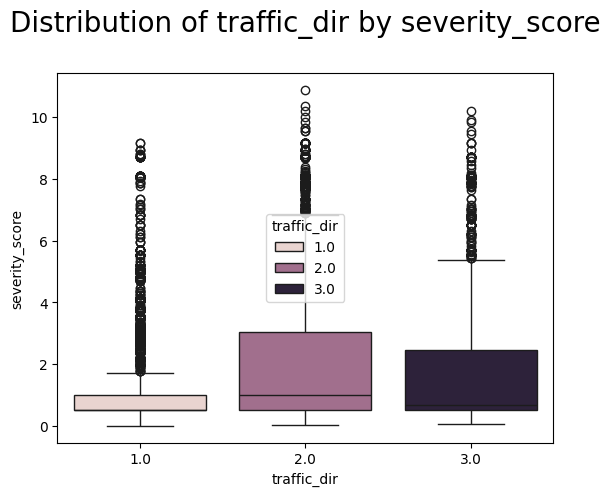

ANOVA Test
F-value of ANOVA between feature and target: 449.27536 at p-value: 0.0


In [35]:
traffic_map = {
    1: 1,
    2: 2,
    3: 3,
    4: 3,
}

train['traffic_dir'] = train['traffic_dir'].map(traffic_map)

train['traffic_dir'] = train['traffic_dir'].fillna(train['traffic_dir'].mode()[0])

var_qual_anal(train, 'traffic_dir', 'severity_score')

In [36]:
dummy_list.append('traffic_dir')

## `num_lanes`

This feature should capture the lanes existing where the accidents happened. However, there are some odd values over 10 (assuming i.e. Champs Elysee as one big street with 8 lanes). Since n over 4 is small and entries over 12 are not realiable, I categorize this into a new value.

| old | new |
| -- | -- | 
|1 | 1 |
| 2 | 2 |
| 3 | 3 |
| 4 | 4 |
| >4 | 5 |
| NA | mode |

Percentage of missings:
 4.49 %

Values of num_lanes 

           Absolute Count  Relative Count (%)
num_lanes                                    
1.0                  9765           10.273648
2.0                 58053           61.076918
3.0                  7399            7.784406
4.0                 10658           11.213164
5.0                  1400            1.472924
6.0                  2374            2.497659
7.0                   221            0.232512
8.0                   650            0.683858
9.0                    73            0.076802
10.0                  133            0.139928
11.0                   21            0.022094
12.0                   32            0.033667
NaN                  4270            4.492420

count    90779.000000
mean         2.437711
std          1.236986
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         12.000000
Name: num_lanes, dtype: float64



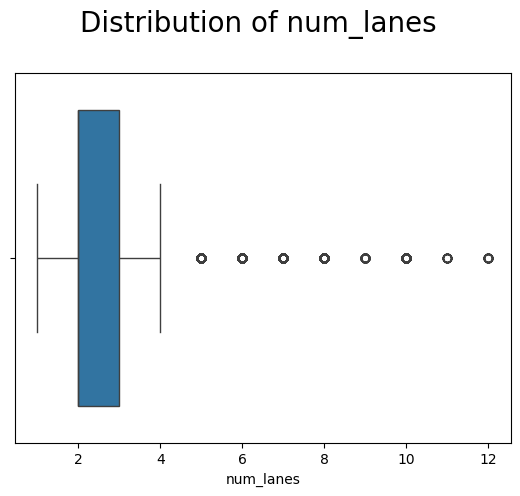

Outliers (1.5*IQR) are outside of:  [nan, nan]
Percentage below the lower threshold: 0.00%
Percentage above the upper threshold: 0.00%
Extreme values (3*IQR) are outside of:  [nan, nan]
Percentage below the lower threshold: 0.00%
Percentage above the upper threshold: 0.00%


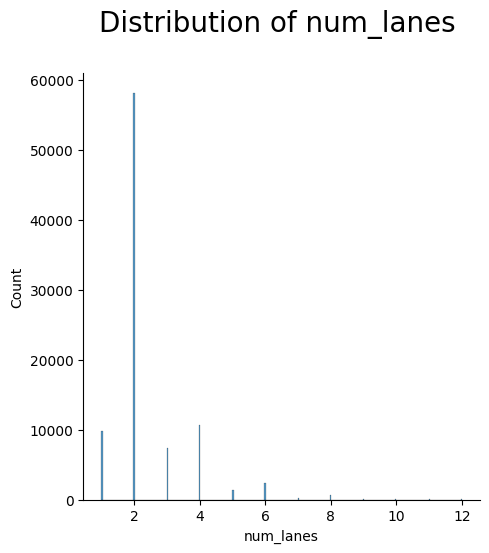

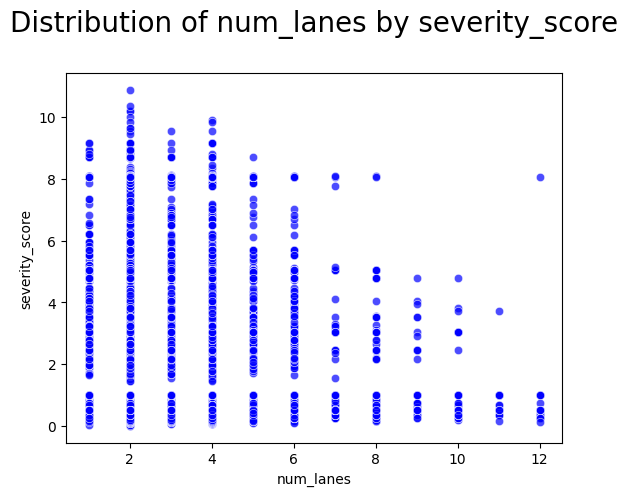

Kendall's tau: -0.09975810731545354, p-value: 7.681994924115423e-294


In [37]:
var_quant_anal(train, 'num_lanes', 'severity_score')

In [38]:
train['num_lanes'] = train['num_lanes'].map(lambda x: 5 if x > 4 else x)

train['num_lanes'] = train['num_lanes'].fillna(train['num_lanes'].mode()[0])

Values of num_lanes 

           Absolute Count  Relative Count (%)
num_lanes                                    
1.0                  9765           10.273648
2.0                 62323           65.569338
3.0                  7399            7.784406
4.0                 10658           11.213164
5.0                  4904            5.159444

Percentage of missings:
 0.0 %



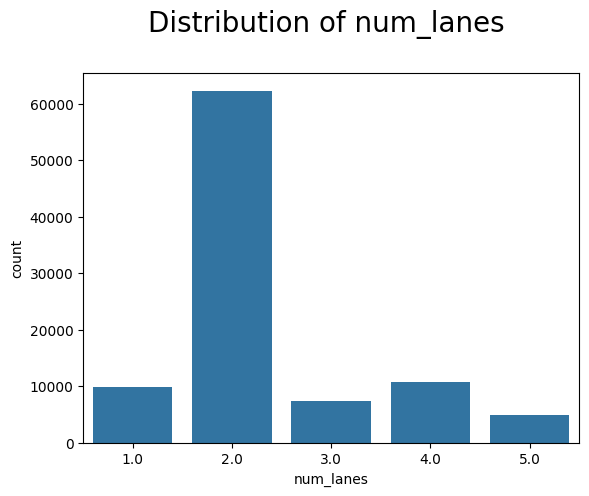

Statistics of num_lanes and severity_score: 

             count      mean       std       min  25%  50%       75%  \
num_lanes                                                              
1.0         9765.0  1.467886  1.611083  0.018519  0.5  0.5  2.784735   
2.0        62323.0  2.048727  1.960144  0.000000  0.5  1.0  3.034735   
3.0         7399.0  1.250340  1.458543  0.066667  0.5  0.5  1.000000   
4.0        10658.0  1.334799  1.562813  0.066667  0.5  0.5  1.000000   
5.0         4904.0  1.106451  1.313686  0.076923  0.5  0.5  1.000000   

                 max  
num_lanes             
1.0         9.153322  
2.0        10.888181  
3.0         9.565205  
4.0         9.898060  
5.0         8.701920  


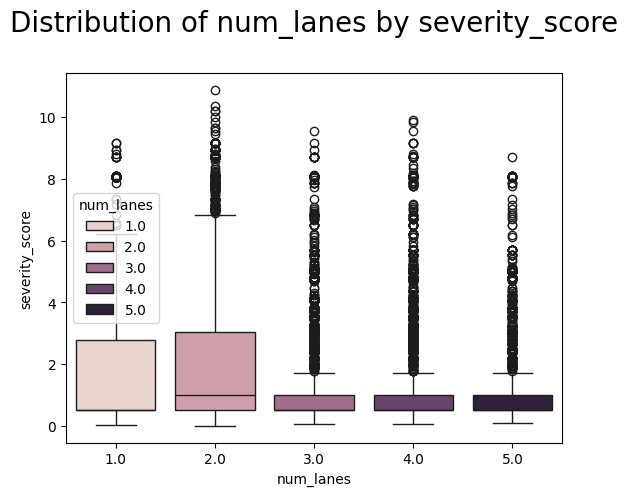

ANOVA Test
F-value of ANOVA between feature and target: 1398.68754 at p-value: 0.0


In [39]:
var_qual_anal(train, 'num_lanes', 'severity_score')

In [40]:
dummy_list.append('num_lanes')

## `prof_road`

|old | description | new |
| -- | ------ | -- |
| 1 | "Flat" | 1 | 
| 2 | "Slope" | 2 |
| 3 | "Top of slope" | 2 |
| 4 | "Bottom of slope" | 2 |
| NA | NA | 1 | 


Values of prof_road 

           Absolute Count  Relative Count (%)
prof_road                                    
1.0                 77403           81.463979
2.0                 14864           15.643846
3.0                  1451            1.527127
4.0                  1297            1.365048

Percentage of missings:
 0.04 %



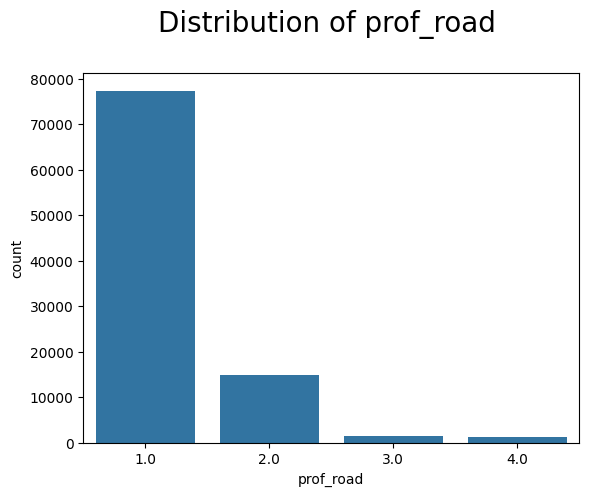

Statistics of prof_road and severity_score: 

             count      mean       std       min  25%       50%       75%  \
prof_road                                                                   
1.0        77403.0  1.699219  1.790597  0.018519  0.5  0.666667  3.034735   
2.0        14864.0  2.195845  2.033867  0.076923  0.5  1.000000  3.225773   
3.0         1451.0  2.382305  2.161586  0.100000  0.5  1.000000  3.392440   
4.0         1297.0  2.473141  2.163181  0.000000  0.5  2.159735  4.047673   

                 max  
prof_road             
1.0        10.888181  
2.0         9.177672  
3.0         9.837407  
4.0         9.177672  


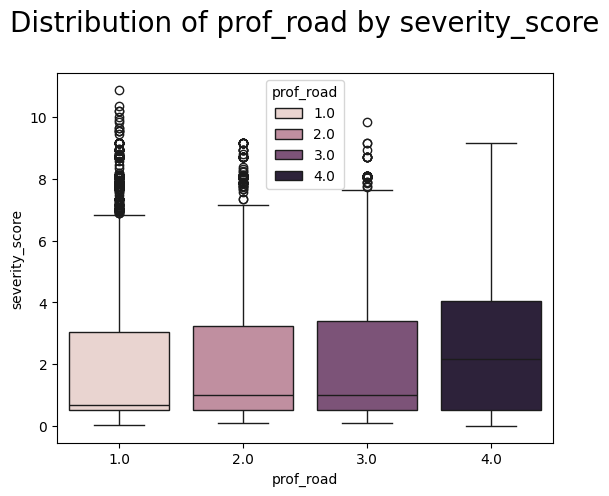

ANOVA Test
F-value of ANOVA between feature and target: 1125.61881 at p-value: 0.0


In [41]:
var_qual_anal(train, 'prof_road', 'severity_score')

In [42]:
profile_map = {
    0: 1, 
    1: 1, 
    2: 2, 
    3: 2, 
    4: 2
}

mode = train['prof_road'].mode()

train['prof_road'] = train['prof_road'].map(profile_map)

train['prof_road'] = train['prof_road'].fillna(train['prof_road'].mode()[0])

Values of prof_road 

           Absolute Count  Relative Count (%)
prof_road                                    
1.0                 77437            81.47061
2.0                 17612            18.52939

Percentage of missings:
 0.0 %



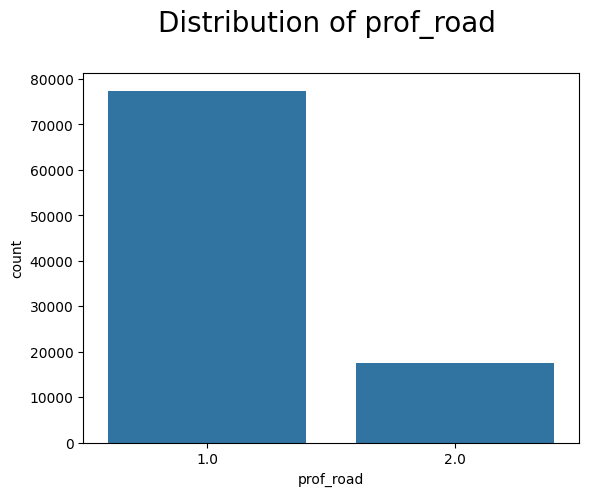

Statistics of prof_road and severity_score: 

             count      mean       std       min  25%       50%       75%  \
prof_road                                                                   
1.0        77437.0  1.699664  1.790841  0.018519  0.5  0.666667  3.034735   
2.0        17612.0  2.231627  2.056076  0.000000  0.5  1.000000  3.225773   

                 max  
prof_road             
1.0        10.888181  
2.0         9.837407  


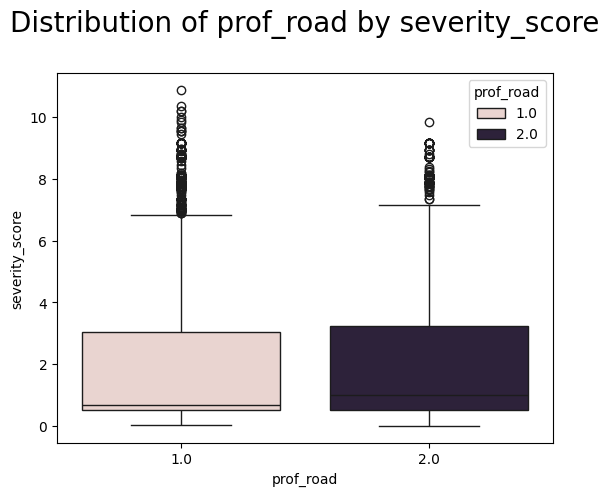

ANOVA Test
F-value of ANOVA between feature and target: 1195.5951 at p-value: 0.0


In [43]:
var_qual_anal(train, 'prof_road', 'severity_score')

In [44]:
dummy_list.append('prof_road')

## `plan_view`


| old | description | new |
| -- | ----- | -- |
| 1 | "Straight section" | 1 |
| 2 | "Left-hand curve" | 2 |
| 3 | "Right-hand curve" | 2 |
| 4 | "S-shaped" | 2 |
| NA | NA | mode |

Values of plan_view 

           Absolute Count  Relative Count (%)
plan_view                                    
1.0                 76742           80.763200
2.0                  8958            9.427390
3.0                  8082            8.505488
4.0                  1239            1.303922

Percentage of missings:
 0.03 %



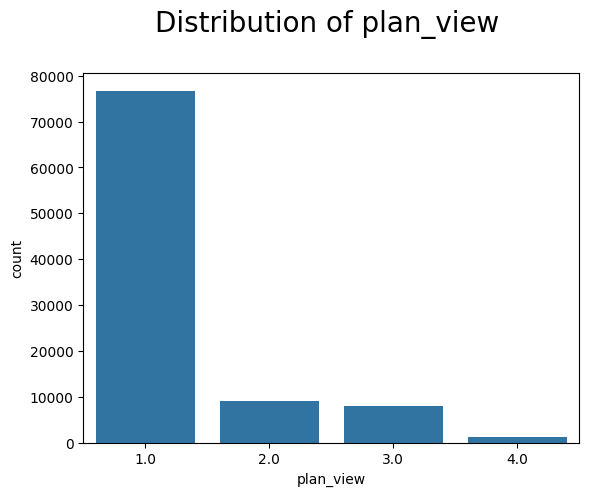

Statistics of plan_view and severity_score: 

             count      mean       std       min  25%       50%       75%  \
plan_view                                                                   
1.0        76742.0  1.624228  1.728003  0.000000  0.5  0.500000  3.034735   
2.0         8958.0  2.481457  2.177927  0.125000  0.5  1.000000  4.784735   
3.0         8082.0  2.533840  2.149817  0.025641  0.5  2.380254  4.187050   
4.0         1239.0  2.814220  2.118616  0.200000  1.0  3.034735  4.784735   

                 max  
plan_view             
1.0        10.207645  
2.0         9.837407  
3.0        10.888181  
4.0         9.153322  


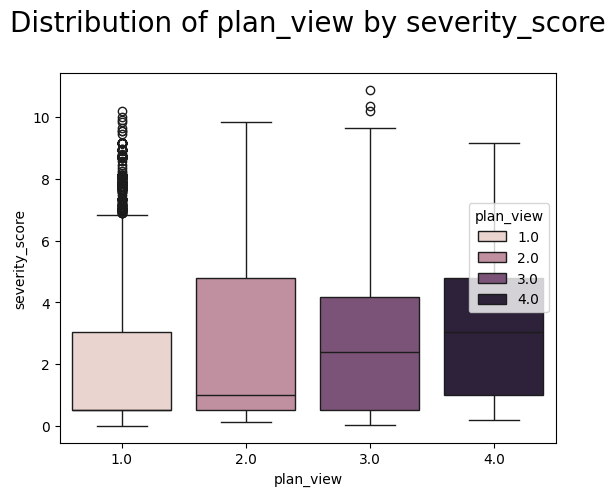

ANOVA Test
F-value of ANOVA between feature and target: 3271.85684 at p-value: 0.0


In [45]:
var_qual_anal(train, 'plan_view', 'severity_score')

In [46]:
plan_map = {
    1: 1,
    2: 2,
    3: 2,
    4: 2,
}

train['plan_view'] = train['plan_view'].map(plan_map)

train['plan_view'] = train['plan_view'].fillna(train['plan_view'].mode()[0])


Values of plan_view 

           Absolute Count  Relative Count (%)
plan_view                                    
1.0                 76770           80.768867
2.0                 18279           19.231133

Percentage of missings:
 0.0 %



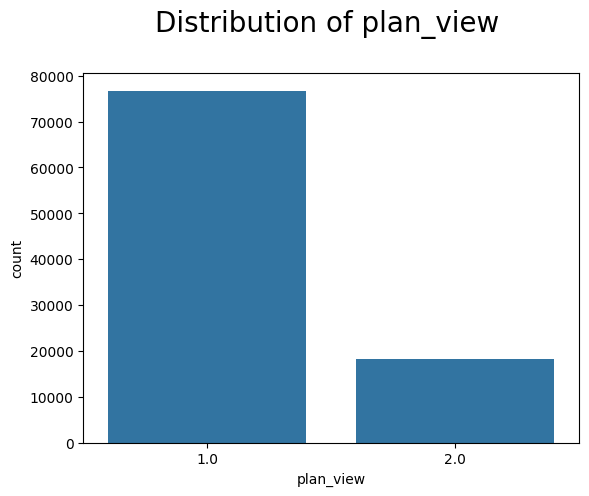

Statistics of plan_view and severity_score: 

             count      mean       std       min  25%       50%       75%  \
plan_view                                                                   
1.0        76770.0  1.624672  1.728329  0.000000  0.5  0.500000  3.034735   
2.0        18279.0  2.527173  2.162968  0.025641  0.5  2.159735  4.784735   

                 max  
plan_view             
1.0        10.207645  
2.0        10.888181  


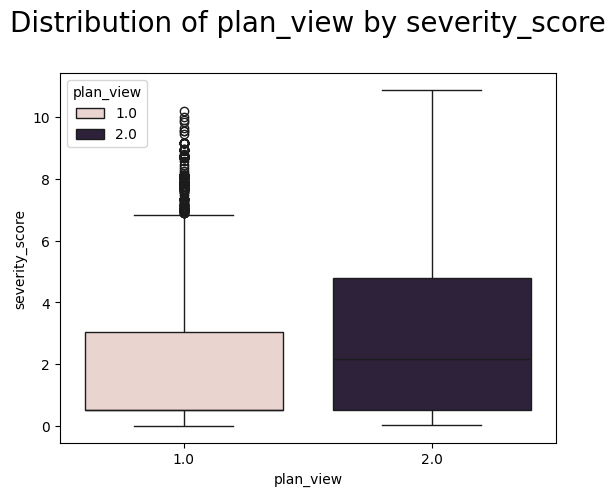

ANOVA Test
F-value of ANOVA between feature and target: 3630.38851 at p-value: 0.0


In [47]:
var_qual_anal(train, 'plan_view', 'severity_score')

dummy_list.append('plan_view')

## `surface`


| old | description | new | 
| -- | ------ | -- |
| 1 | "Normal" | 1 |
| 2 | "Wet" | 2 |
| 3 | "Puddled" | 2 |
| 4 | "Flooded" | 2 |
| 5 | "Snowy" | 2 |
| 6 | "Muddy" | 2 |
| 7 | "Icy" | 2 |
| 8 | "Grease - Oil" | 2 |
| 9 | "Other" | 2 |
| NA | NA | mode |

Values of surface 

         Absolute Count  Relative Count (%)
surface                                    
1.0               76078           80.077891
2.0               17458           18.375875
3.0                 162            0.170517
4.0                  41            0.043156
5.0                 174            0.183148
6.0                  66            0.069470
7.0                 397            0.417873
8.0                 149            0.156834
9.0                 480            0.505237

Percentage of missings:
 0.05 %



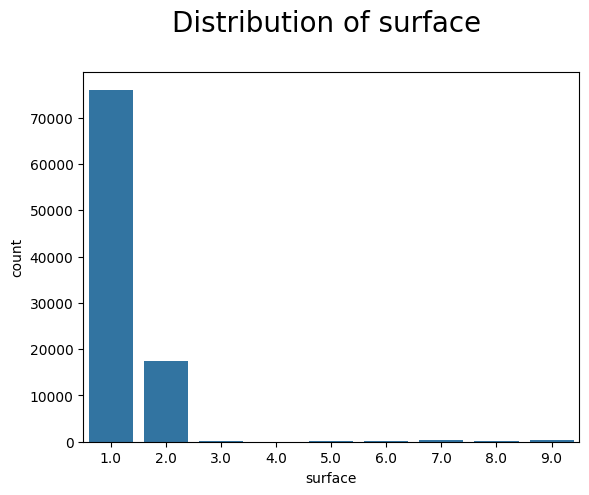

Statistics of surface and severity_score: 

           count      mean       std       min  25%       50%       75%  \
surface                                                                   
1.0      76078.0  1.794332  1.842464  0.000000  0.5  0.666667  3.034735   
2.0      17458.0  1.751121  1.867465  0.076923  0.5  0.800000  3.034735   
3.0        162.0  1.949828  1.880907  0.200000  0.5  1.000000  3.034735   
4.0         41.0  1.996907  2.236565  0.200000  0.5  0.833333  3.034735   
5.0        174.0  2.163125  1.938191  0.142857  0.5  1.000000  3.084010   
6.0         66.0  3.565983  2.491067  0.166667  1.0  4.416204  4.784735   
7.0        397.0  2.535000  2.172168  0.200000  1.0  1.000000  4.381006   
8.0        149.0  2.004209  1.703698  0.200000  1.0  1.000000  3.534735   
9.0        480.0  2.909698  2.120013  0.166667  1.0  3.034735  4.784735   

               max  
surface             
1.0      10.888181  
2.0      10.010423  
3.0       8.047673  
4.0       8.047673  
5.0 

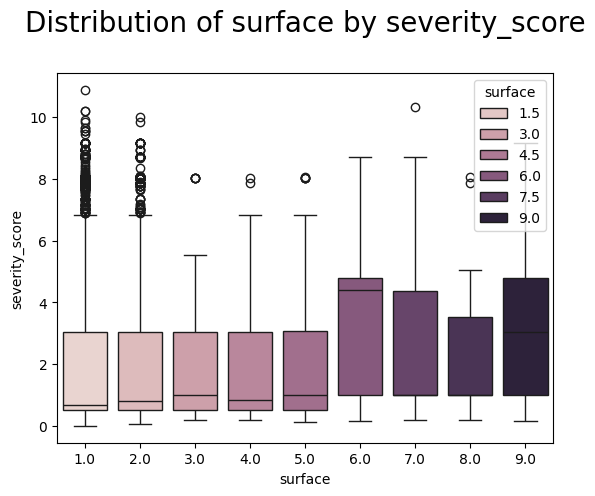

ANOVA Test
F-value of ANOVA between feature and target: 172.3095 at p-value: 0.0


In [48]:
var_qual_anal(train, 'surface', 'severity_score')

In [49]:
train['surface'] = train['surface'].map(lambda x: 2 if x > 1 else x)

train['surface'] = train['surface'].fillna(train['surface'].mode()[0])

Values of surface 

         Absolute Count  Relative Count (%)
surface                                    
1.0               76122           80.087113
2.0               18927           19.912887

Percentage of missings:
 0.0 %



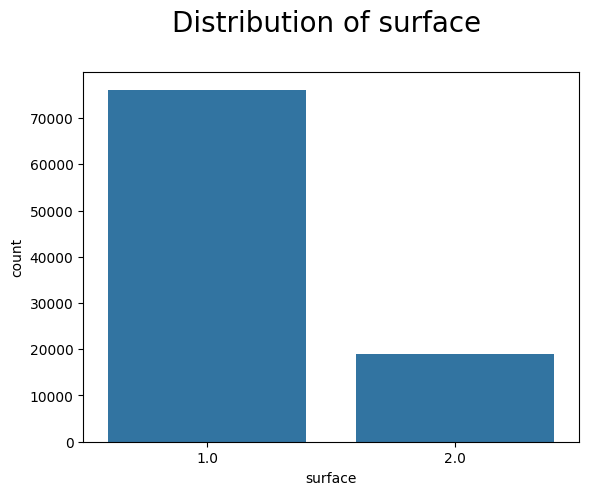

Statistics of surface and severity_score: 

           count      mean       std       min  25%       50%       75%  \
surface                                                                   
1.0      76122.0  1.794988  1.843202  0.000000  0.5  0.666667  3.034735   
2.0      18927.0  1.811287  1.898831  0.076923  0.5  1.000000  3.034735   

               max  
surface             
1.0      10.888181  
2.0      10.349940  


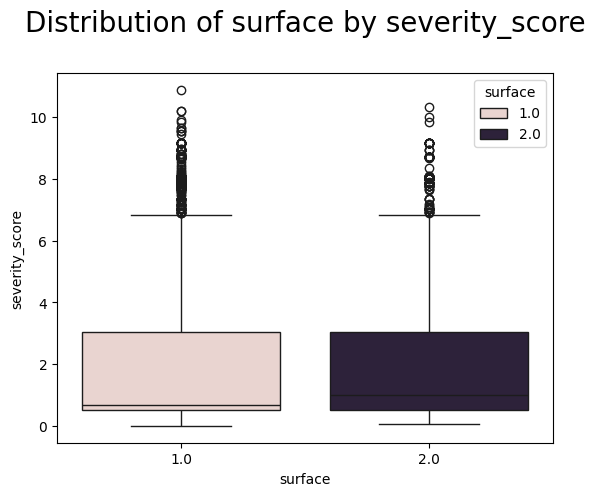

ANOVA Test
F-value of ANOVA between feature and target: 1.17108 at p-value: 0.27918


In [50]:
var_qual_anal(train, 'surface', 'severity_score')

In [51]:
dummy_list.append('surface')

## `acc_loc`

| old | description | new | 
| -- | ------ | -- |
| 1 | "On carriageway" | 1 |
| 2 | "On hard shoulder" | 2 |
| 3 | "On shoulder" | 2 |
| 4 | "On sidewalk" | 2 |
| 5 | "On cycle track" | 2 |
| 6 | "On other special lanes" | 2 |
| 8 | "Other" | 2 |
| NA | NA | mode |

Values of acc_loc 

         Absolute Count  Relative Count (%)
acc_loc                                    
1.0               78507           82.651998
2.0                 735            0.773806
3.0                6994            7.363268
4.0                2114            2.225615
5.0                2340            2.463547
6.0                1125            1.184398
8.0                3170            3.337369

Percentage of missings:
 0.07 %



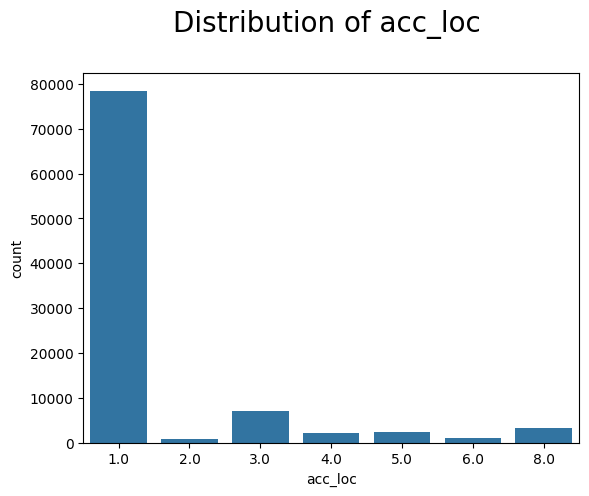

Statistics of acc_loc and severity_score: 

           count      mean       std       min  25%       50%       75%  \
acc_loc                                                                   
1.0      78507.0  1.578262  1.632501  0.000000  0.5  0.500000  3.034735   
2.0        735.0  2.094085  2.099269  0.125000  0.5  1.000000  3.034735   
3.0       6994.0  3.837534  2.366047  0.027778  1.0  4.784735  4.784735   
4.0       2114.0  2.389572  2.247703  0.125000  0.5  1.000000  4.784735   
5.0       2340.0  1.141086  1.318748  0.200000  0.5  0.500000  1.000000   
6.0       1125.0  1.466196  1.648755  0.111111  0.5  0.500000  3.034735   
8.0       3170.0  2.886890  2.429061  0.166667  0.5  3.034735  4.784735   

               max  
acc_loc             
1.0      10.888181  
2.0       8.465606  
3.0       9.177672  
4.0      10.010423  
5.0       8.701920  
6.0       8.082408  
8.0      10.349940  


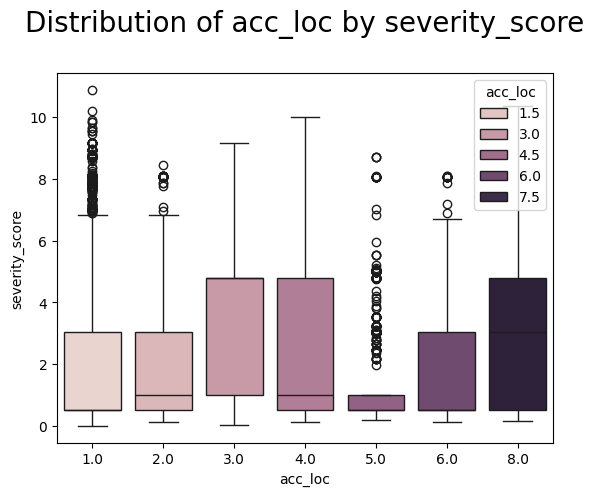

ANOVA Test
F-value of ANOVA between feature and target: 3046.89978 at p-value: 0.0


In [52]:
var_qual_anal(train, 'acc_loc', 'severity_score')

In [53]:
train['acc_loc'] = train['acc_loc'].map(lambda x: 2 if x > 1 else x)

train['acc_loc'] = train['acc_loc'].fillna(train['acc_loc'].mode()[0])

Values of acc_loc 

         Absolute Count  Relative Count (%)
acc_loc                                    
1.0               78571           82.663679
2.0               16478           17.336321

Percentage of missings:
 0.0 %



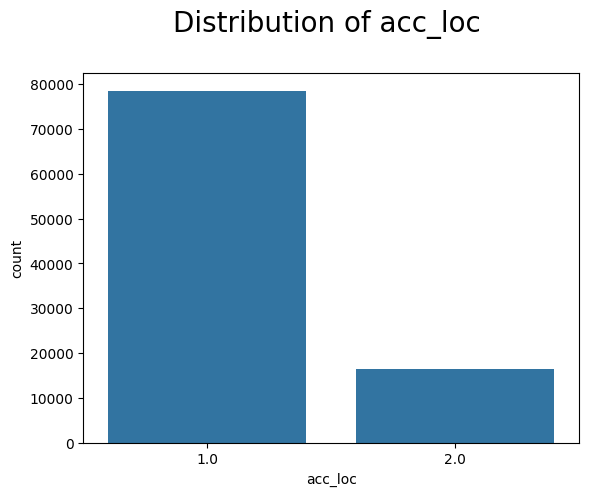

Statistics of acc_loc and severity_score: 

           count      mean       std       min  25%       50%       75%  \
acc_loc                                                                   
1.0      78571.0  1.578430  1.632522  0.000000  0.5  0.500000  3.034735   
2.0      16478.0  2.846309  2.408239  0.027778  0.5  2.451402  4.784735   

               max  
acc_loc             
1.0      10.888181  
2.0      10.349940  


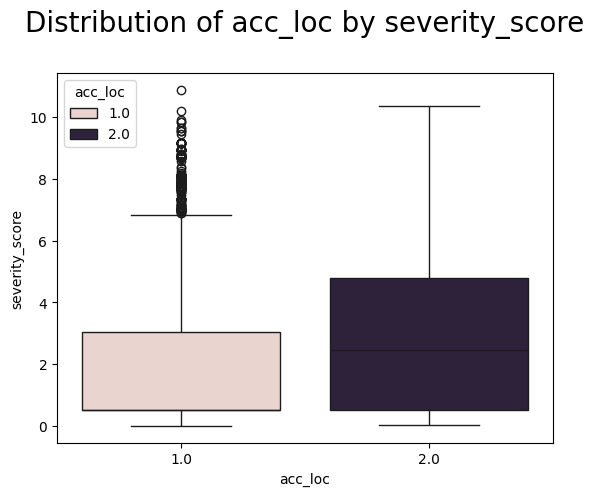

ANOVA Test
F-value of ANOVA between feature and target: 6824.50165 at p-value: 0.0


In [54]:
var_qual_anal(train, 'acc_loc', 'severity_score')

In [55]:
dummy_list.append('acc_loc')

In [56]:
print(dummy_list)
print(cyclical_list)
print(robust_list)
print(minmax_list)
print(standard_list)
print(targetenc_list)

['light_condit', 'location_type', 'intersect_type', 'weather_cond', 'collision_type', 'year', 'road_cat', 'traffic_dir', 'num_lanes', 'prof_road', 'surface', 'acc_loc']
['month', 'weekday', 'hour']
[]
[]
[]
[]


# Column Processing

Table of mappings and settings

| feature | regrouping | transformation | 
| ---- | ------ | -------- |
| `lat` | - | transform to radiant |
| `long` | - | transform to radiant |
| `light_condit` | minimized groups | dummy-coded |
| `location_type` | - | dummy-coded for urban (2) | 
| `intersect_type` | minimized groups | dummy-coded |
| `weather_cond` | minimized groups | dummy-coded for normal conditions (1) |
| `collision_type` | minimized groups | dummy-coded |
| `month` | - | cyclical encoding  |
| `weekday` | - | cyclical encoding |
| `hour` | - | cyclical encoding: |
| `year` | -  | MinMax-Scaling |
| `road_cat` | minimized groups | dummy-coded |
| `traffic_dir` | minimized groups | dummy-coded |
| `num_lanes` | minimized groups | dummy-coded |
| `prof_road` | minimized groups | dummy-coded to flat (1) |
| `plan_view` | minimized groups | dummy-coded to straight (1) |
| `surface` | minimized groups | dummy-coded to normal (1) |
| `acc_loc` | minimized groups | dummy-coded to on carriageway (1) |

Here, I do the regrouping. Afterwards, I create a `ColumnTransformer` to handle each case and transform the input with the following steps:

1. transforming lattitude and longitude features
1. encoding qualitative features with more than 2 groups
1. encoding qualitative features with 2 groups

## Mutations

In [57]:
train = pd.read_csv('data/processed/train_raw.csv', index_col=0)
test = pd.read_csv('data/processed/test_raw.csv', index_col=0)

### Grouping for categorical features

In [58]:
light_map = {1: 1, 2: 2, 3: 3, 4: 4, 5: 4}
train['light_condit'] = train['light_condit'].map(light_map)
train['light_condit'] = train['light_condit'].fillna(train['light_condit'].mode()[0])
test['light_condit'] = test['light_condit'].map(light_map)
test['light_condit'] = test['light_condit'].fillna(test['light_condit'].mode()[0])

In [59]:
loc_map = {1: 0, 2: 1}
train['urban'] = train['location_type'].map(loc_map)
train['urban'] = train['urban'].fillna(train['urban'].mode()[0])
train.drop(columns='location_type', axis=1, inplace=True)

test['urban'] = test['location_type'].map(loc_map)
test['urban'] = test['urban'].fillna(test['urban'].mode()[0])
test.drop(columns='location_type', axis=1, inplace=True)

In [60]:
intersect_map = {1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 3}
train['intersect_type'] = train['intersect_type'].map(intersect_map)
train['intersect_type'] = train['intersect_type'].fillna(train['intersect_type'].mode()[0])
test['intersect_type'] = test['intersect_type'].map(intersect_map)
test['intersect_type'] = test['intersect_type'].fillna(test['intersect_type'].mode()[0])

In [61]:
weather_map = {1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

train['weather_normal'] = train['weather_cond'].map(weather_map)
train['weather_normal'] = train['weather_normal'].fillna(train['weather_normal'].mode()[0])
train.drop(columns='weather_cond', axis=1, inplace=True)

test['weather_normal'] = test['weather_cond'].map(weather_map)
test['weather_normal'] = test['weather_normal'].fillna(test['weather_normal'].mode()[0])
test.drop(columns='weather_cond', axis=1, inplace=True)

In [62]:
col_map = {1: 1, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2, 7: 3}
train['collision_type'] = train['collision_type'].map(col_map)
train['collision_type'] = train['collision_type'].fillna(train['collision_type'].mode()[0])
test['collision_type'] = test['collision_type'].map(col_map)
test['collision_type'] = test['collision_type'].fillna(test['collision_type'].mode()[0])

In [63]:
road_map = {1: 1, 2: 1, 3: 2, 4: 3, 5: 3, 6: 3, 7: 3, 9: 3}
train['road_cat'] = train['road_cat'].map(road_map)
train['road_cat'] = train['road_cat'].fillna(train['road_cat'].mode()[0])
test['road_cat'] = test['road_cat'].map(road_map)
test['road_cat'] = test['road_cat'].fillna(test['road_cat'].mode()[0])

In [64]:
traffic_map = {1: 1, 2: 2, 3: 3, 4: 3}
train['traffic_dir'] = train['traffic_dir'].map(traffic_map)
train['traffic_dir'] = train['traffic_dir'].fillna(train['traffic_dir'].mode()[0])
test['traffic_dir'] = test['traffic_dir'].map(traffic_map)
test['traffic_dir'] = test['traffic_dir'].fillna(test['traffic_dir'].mode()[0])

In [65]:
train['num_lanes'] = train['num_lanes'].apply(lambda x: 5 if x > 4 else x)
train['num_lanes'] = train['num_lanes'].fillna(train['num_lanes'].mode()[0])

test['num_lanes'] = test['num_lanes'].apply(lambda x: 5 if x > 4 else x)
test['num_lanes'] = test['num_lanes'].fillna(test['num_lanes'].mode()[0])

In [66]:
prof_map = {1: 1, 2: 0, 3: 0, 4: 0}
train['prof_flat'] = train['prof_road'].map(prof_map)
train['prof_flat'] = train['prof_flat'].fillna(train['prof_flat'].mode()[0])
train.drop(columns='prof_road', axis=1, inplace=True)

test['prof_flat'] = test['prof_road'].map(prof_map)
test['prof_flat'] = test['prof_flat'].fillna(test['prof_flat'].mode()[0])
test.drop(columns='prof_road', axis=1, inplace=True)

In [67]:
plan_map = {1: 1, 2: 0, 3: 0, 4: 0}
train['straight_view'] = train['plan_view'].map(plan_map)
train['straight_view'] = train['straight_view'].fillna(train['straight_view'].mode()[0])
train.drop(columns='plan_view', axis=1, inplace=True)

test['straight_view'] = test['plan_view'].map(plan_map)
test['straight_view'] = test['straight_view'].fillna(test['straight_view'].mode()[0])
test.drop(columns='plan_view', axis=1, inplace=True)

In [68]:
train['surface_normal'] = train['surface'].map(lambda x: 2 if x > 1 else x)
train['surface_normal'] = train['surface_normal'].fillna(train['surface_normal'].mode()[0])
train.drop(columns=['surface'], axis=1, inplace=True)

test['surface_normal'] = test['surface'].map(lambda x: 2 if x > 1 else x)
test['surface_normal'] = test['surface_normal'].fillna(test['surface_normal'].mode()[0])
test.drop(columns=['surface'], axis=1, inplace=True)

In [69]:
train['on_road'] = train['acc_loc'].map(lambda x: 2 if x > 1 else x)
train['on_road'] = train['on_road'].fillna(train['on_road'].mode()[0])
train.drop(columns=['acc_loc'], axis=1, inplace=True)

test['on_road'] = test['acc_loc'].map(lambda x: 2 if x > 1 else x)
test['on_road'] = test['on_road'].fillna(test['on_road'].mode()[0])
test.drop(columns=['acc_loc'], axis=1, inplace=True)

### Cycylical mutation

In [70]:
train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)
train['hour_sin'] = np.sin(2 * np.pi * train['hour'] / 24)
train['hour_cos'] = np.cos(2 * np.pi * train['hour'] / 24)
train['weekday_sin'] = np.sin(2 * np.pi * train['weekday'] / 7)
train['weekday_cos'] = np.cos(2 * np.pi * train['weekday'] / 7)
train.drop(columns=['month', 'hour', 'weekday'], axis=1, inplace=True)

test['month_sin'] = np.sin(2 * np.pi * test['month'] / 12)
test['month_cos'] = np.cos(2 * np.pi * test['month'] / 12)
test['hour_sin'] = np.sin(2 * np.pi * test['hour'] / 24)
test['hour_cos'] = np.cos(2 * np.pi * test['hour'] / 24)
test['weekday_sin'] = np.sin(2 * np.pi * test['weekday'] / 7)
test['weekday_cos'] = np.cos(2 * np.pi * test['weekday'] / 7)
test.drop(columns=['month', 'hour', 'weekday'], axis=1, inplace=True)

In [71]:
# dropping date and year
train.drop(columns=['date', 'year'], inplace=True)
test.drop(columns=['date', 'year'], inplace=True)

In [72]:
train.to_csv('data/processed/train_eng.csv', index=False)
test.to_csv('data/processed/test_eng.csv', index=False)